## Classify Dermatology Disease Classes
- Problem: Hard to diagnose different dermatology diseases because they have similar clinical and histopathological features
- Goals: 
    1. Use different classifiers to classify diseases:
        - Dummy classifier as baseline
        - Logistic regression
        - Support vector classifier
        - Random forest
        - Gradient boosting
        - XGBoost
        
    2. Evaluate classifiers by various metrics (F1, AP, PRC, AUROC)
    3. Plot ROC and PRC
    4. Identify important features
      
- Data source: https://archive.ics.uci.edu/ml/datasets/Dermatology        

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.getcwd()

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.impute import SimpleImputer


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
                            roc_curve, confusion_matrix, auc, make_scorer, classification_report, plot_roc_curve,\
                            cohen_kappa_score, average_precision_score, precision_recall_curve
from sklearn.pipeline import Pipeline

'C:\\Users\\tuttoaposto\\Desktop\\My_Py_Projects\\OpenSource\\Derm_Classification'

### Import Data

In [8]:
col_name = ['erythema', 
            'scaling', 
            'definite borders', 
            'itching', 
            'koebner phenomenon', 
            'polygonal papules', 
            'follicular papules', 
            'oral mucosal involvement', 
            'knee and elbow involvement', 
            'scalp involvement', 
            'family history, (0 or 1)', 
            'melanin incontinence', 
            'eosinophils in the infiltrate', 
            'PNL infiltrate', 
            'fibrosis of the papillary dermis', 
            'exocytosis', 
            'acanthosis', 
            'hyperkeratosis', 
            'parakeratosis', 
            'clubbing of the rete ridges', 
            'elongation of the rete ridges', 
            'thinning of the suprapapillary epidermis', 
            'spongiform pustule', 
            'munro microabcess', 
            'focal hypergranulosis', 
            'disappearance of the granular layer', 
            'vacuolisation and damage of basal layer', 
            'spongiosis', 
            'saw-tooth appearance of retes', 
            'follicular horn plug', 
            'perifollicular parakeratosis', 
            'inflammatory monoluclear inflitrate', 
            'band-like infiltrate', 
            'Age (linear)', 
            'Class_Code']

df = pd.read_csv(r'C:\Users\tuttoaposto\Desktop\My_Py_Projects\OpenSource\Derm_Clustering\derm.txt', sep=",", names=col_name, na_values='?')
df['Class'] = df['Class_Code'].map({1: 'psoriasis',
                                    2: 'seboreic dermatitis',
                                    3: 'lichen planus',
                                    4: 'pityriasis rosea',
                                    5: 'cronic dermatitis',
                                    6: 'pityriasis rubra pilaris'})
df.head()

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,...,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age (linear),Class_Code,Class
0,2,2,0,3,0,0,0,0,1,0,...,0,3,0,0,0,1,0,55.0,2,seboreic dermatitis
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,1,0,8.0,1,psoriasis
2,2,1,2,3,1,3,0,3,0,0,...,2,3,2,0,0,2,3,26.0,3,lichen planus
3,2,2,2,0,0,0,0,0,3,2,...,0,0,0,0,0,3,0,40.0,1,psoriasis
4,2,3,2,2,2,2,0,2,0,0,...,3,2,3,0,0,2,3,45.0,3,lichen planus


In [9]:
df.groupby(['Class_Code', 'Class']).size()

Class_Code  Class                   
1           psoriasis                   112
2           seboreic dermatitis          61
3           lichen planus                72
4           pityriasis rosea             49
5           cronic dermatitis            52
6           pityriasis rubra pilaris     20
dtype: int64

### Check Distribution

In [10]:
# df.dtypes
sum(df['Age (linear)'].isna())
df.iloc[:, 0:10].describe()
df.iloc[:, 10:20].describe()
df.iloc[:, 20:30].describe()
df.iloc[:, 30:].describe()

8

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2.068306,1.795082,1.549180,1.366120,0.633880,0.448087,0.166667,0.377049,0.614754,0.519126
std,0.664753,0.701527,0.907525,1.138299,0.908016,0.957327,0.570588,0.834147,0.982979,0.905639
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


,"family history, (0 or 1)",melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.125683,0.404372,0.139344,0.546448,0.336066,1.368852,1.956284,0.527322,1.289617,0.663934
std,0.331946,0.869818,0.411790,0.815451,0.853139,1.104418,0.712512,0.757116,0.917562,1.056829
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,2.000000
max,1.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.991803,0.633880,0.295082,0.363388,0.393443,0.464481,0.456284,0.953552,0.453552,0.103825
std,1.162161,1.034924,0.670578,0.759721,0.849406,0.864899,0.954873,1.130172,0.954744,0.450433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age (linear),Class_Code
count,366.000000,366.000000,366.000000,358.000000,366.000000
mean,0.114754,1.866120,0.554645,36.296089,2.803279
std,0.488723,0.726108,1.105908,15.324557,1.597803
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,25.000000,1.000000
50%,0.000000,2.000000,0.000000,35.000000,3.000000
75%,0.000000,2.000000,0.000000,49.750000,4.000000
max,3.000000,3.000000,3.000000,75.000000,6.000000


In [11]:
#Percetage of feature values = 0
l = pd.DataFrame(zip((df.iloc[:, :-3]==0).sum(), (df.iloc[:, :-3]==1).sum(), (df.iloc[:, :-3]==2).sum(), (df.iloc[:, :-3]==3).sum()),
             columns=['n_0', 'n_1', 'n_2', 'n_3'],
            index=df.columns[:-3])
l['pct_0']=l['n_0']/l.sum(axis=1)
l

,n_0,n_1,n_2,n_3,pct_0
erythema,4,57,215,90,0.010929
scaling,8,111,195,52,0.021858
definite borders,59,93,168,46,0.161202
itching,118,72,100,76,0.322404
koebner phenomenon,224,70,54,18,0.612022
polygonal papules,297,1,41,27,0.811475
follicular papules,333,11,16,6,0.909836
oral mucosal involvement,299,9,45,13,0.816940
knee and elbow involvement,251,28,64,23,0.685792
scalp involvement,264,30,56,16,0.721311


<IPython.core.display.Javascript object>


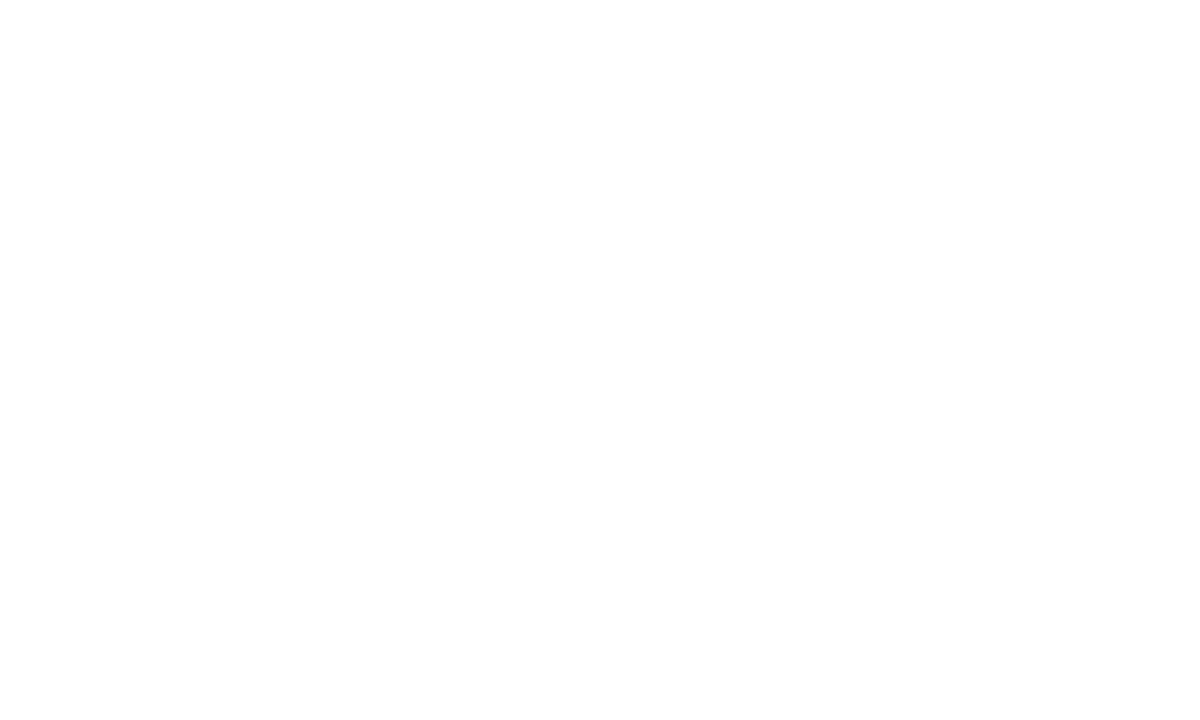

In [12]:
%matplotlib notebook
fig, [ax1, ax2] = plt.subplots(figsize=(10,6), nrows=2, ncols=4)
    
for k, ax in enumerate([ax1, ax2]):
    if k==0:
        cols = ['erythema', 
                'scaling', 
                'definite borders', 
                'itching']
    if k==1:
        cols = ['clubbing of the rete ridges',
                'elongation of the rete ridges',
                'follicular papules',
                'band-like infiltrate']
    for i, col in enumerate(cols):
        sns.violinplot(x = col, data=df, ax=ax[i])
       

fig.subplots_adjust(left=0.05, hspace = 0.25)
pass;

<IPython.core.display.Javascript object>


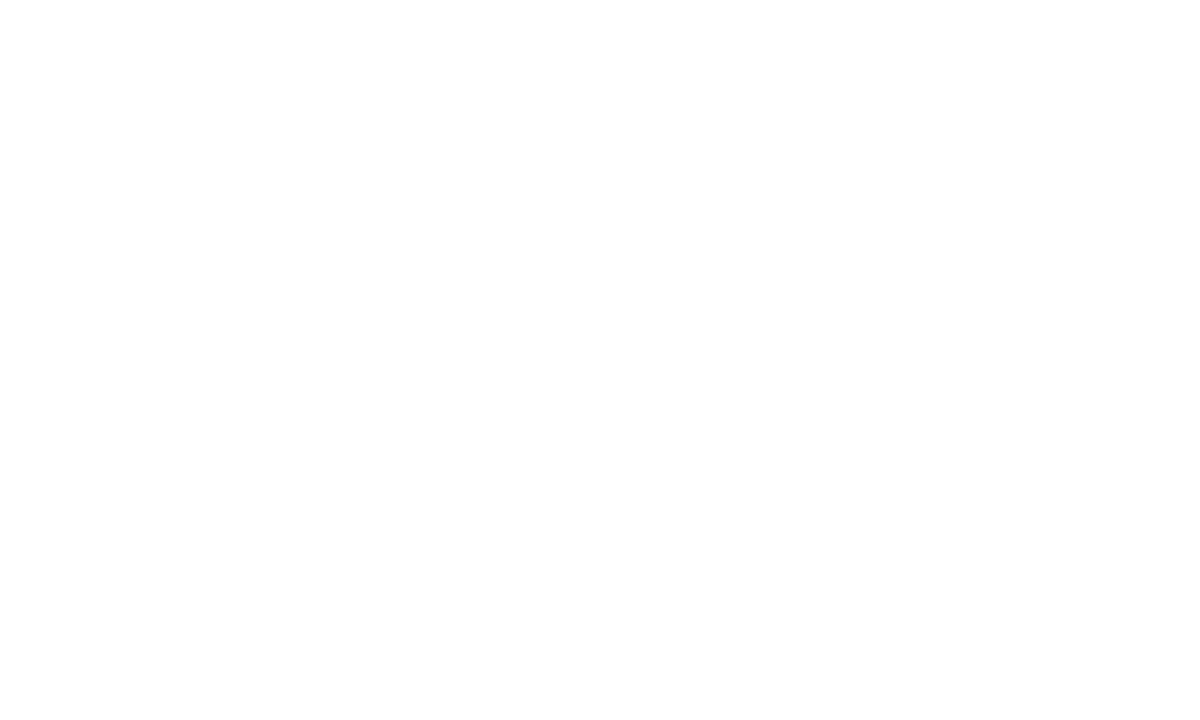

<IPython.core.display.Javascript object>


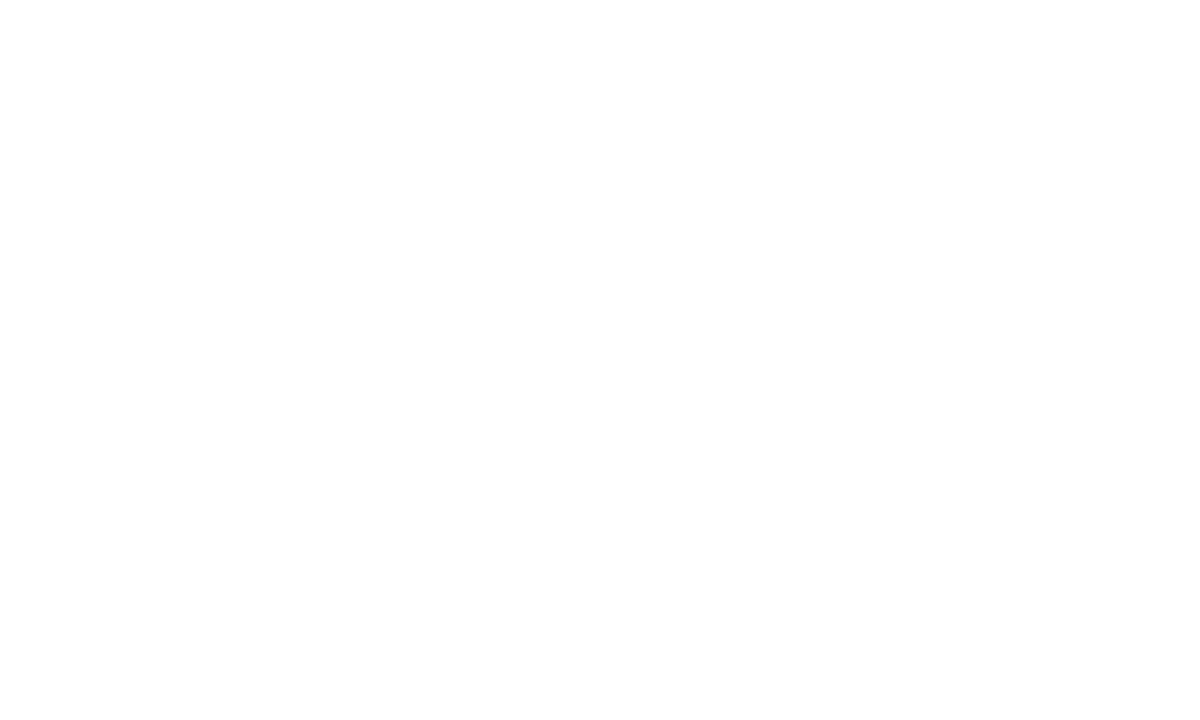

In [13]:
%matplotlib notebook
plt.figure(figsize=(10,6))
plt.title("Ages Frequency")
sns.axes_style("dark")
sns.violinplot(x = 'Age (linear)', data=df)

plt.figure(figsize=(10,6))
ax=sns.violinplot(x = 'Age (linear)', y = 'Class', data=df.sort_values(by='Class_Code'))
ax.set_yticklabels(labels=['psoriasis',
                          'seboreic\ndermatitis',
                          'lichen\nplanus',
                          'pityriasis\nrosea',
                          'cronic\ndermatitis',
                          'pityriasis\nrubra pilaris']);

- Majority of the patients were aged 30 - 50 years
- Patients with pitriasis rubra pilaris were under age 30 years

### Correlation between Features

<IPython.core.display.Javascript object>


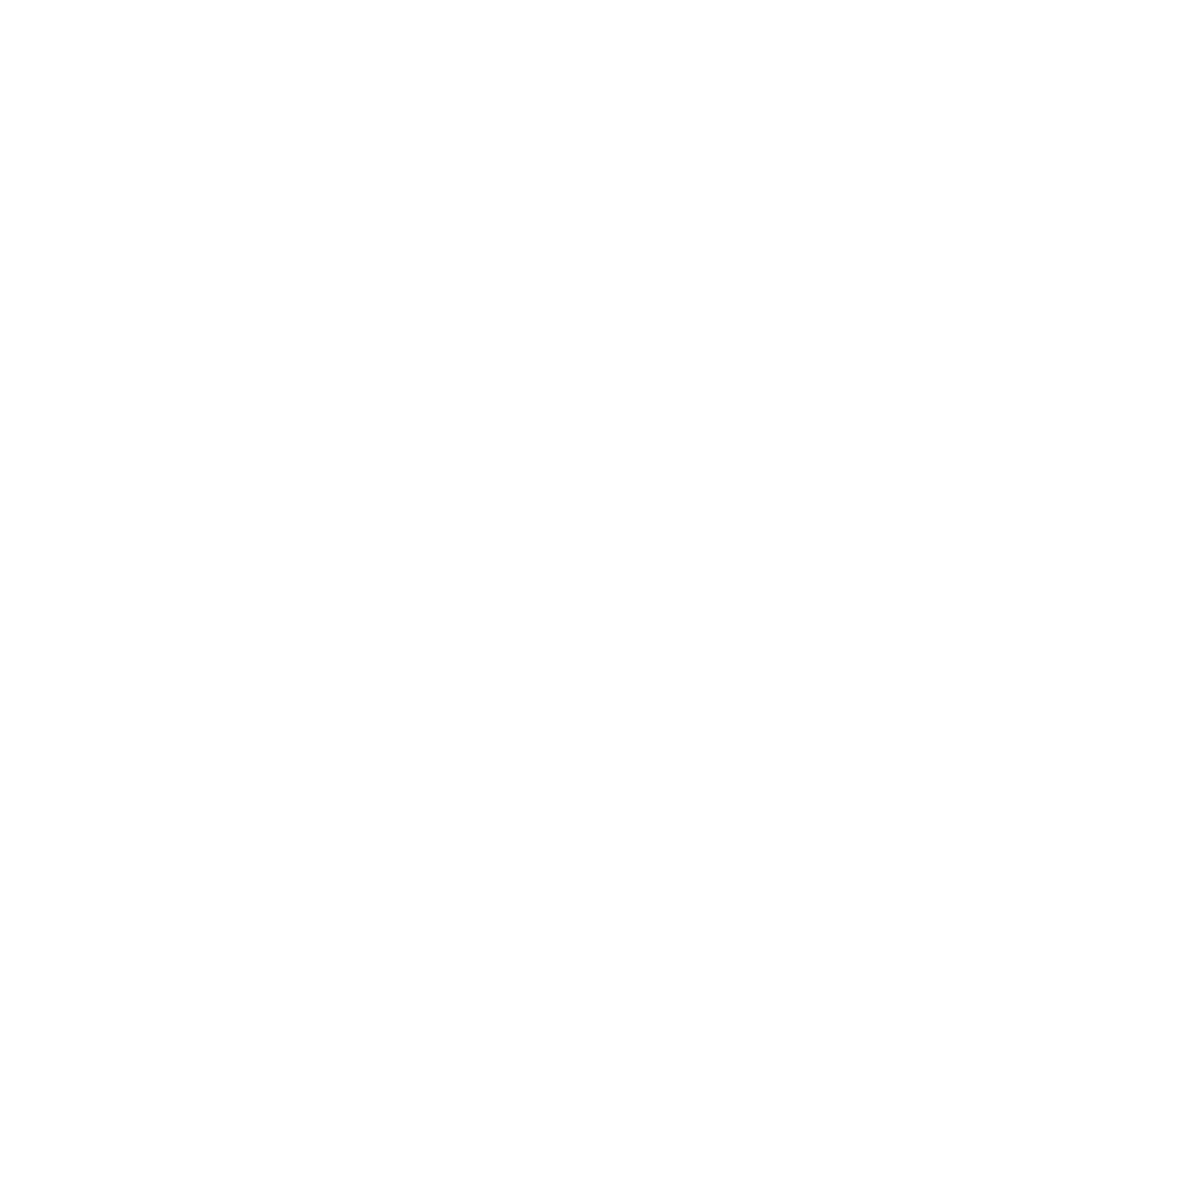

<IPython.core.display.Javascript object>


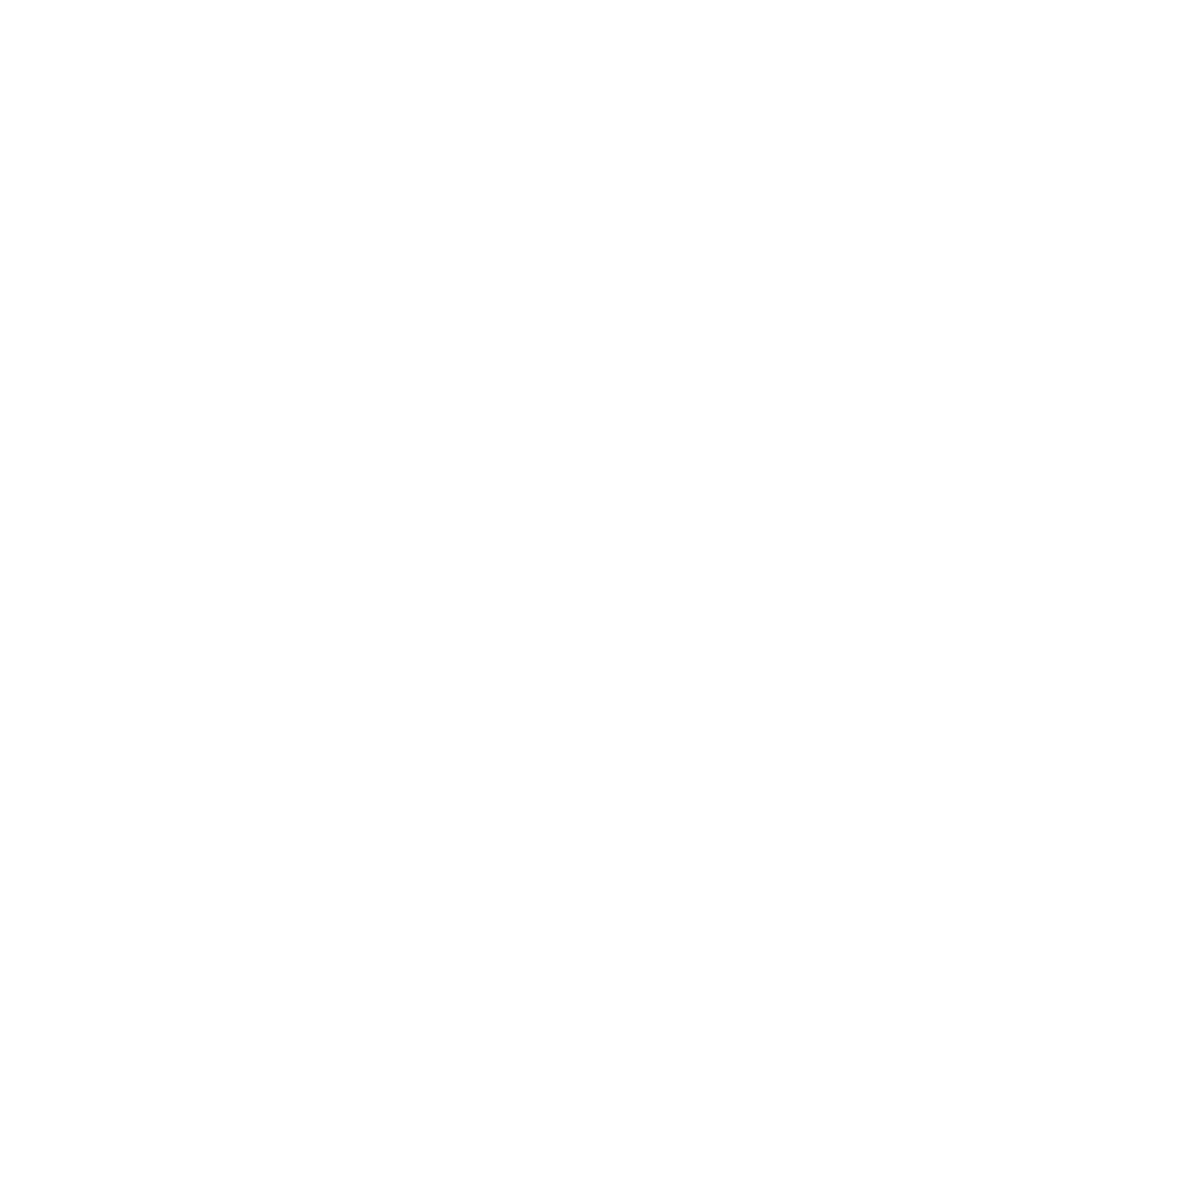

<IPython.core.display.Javascript object>


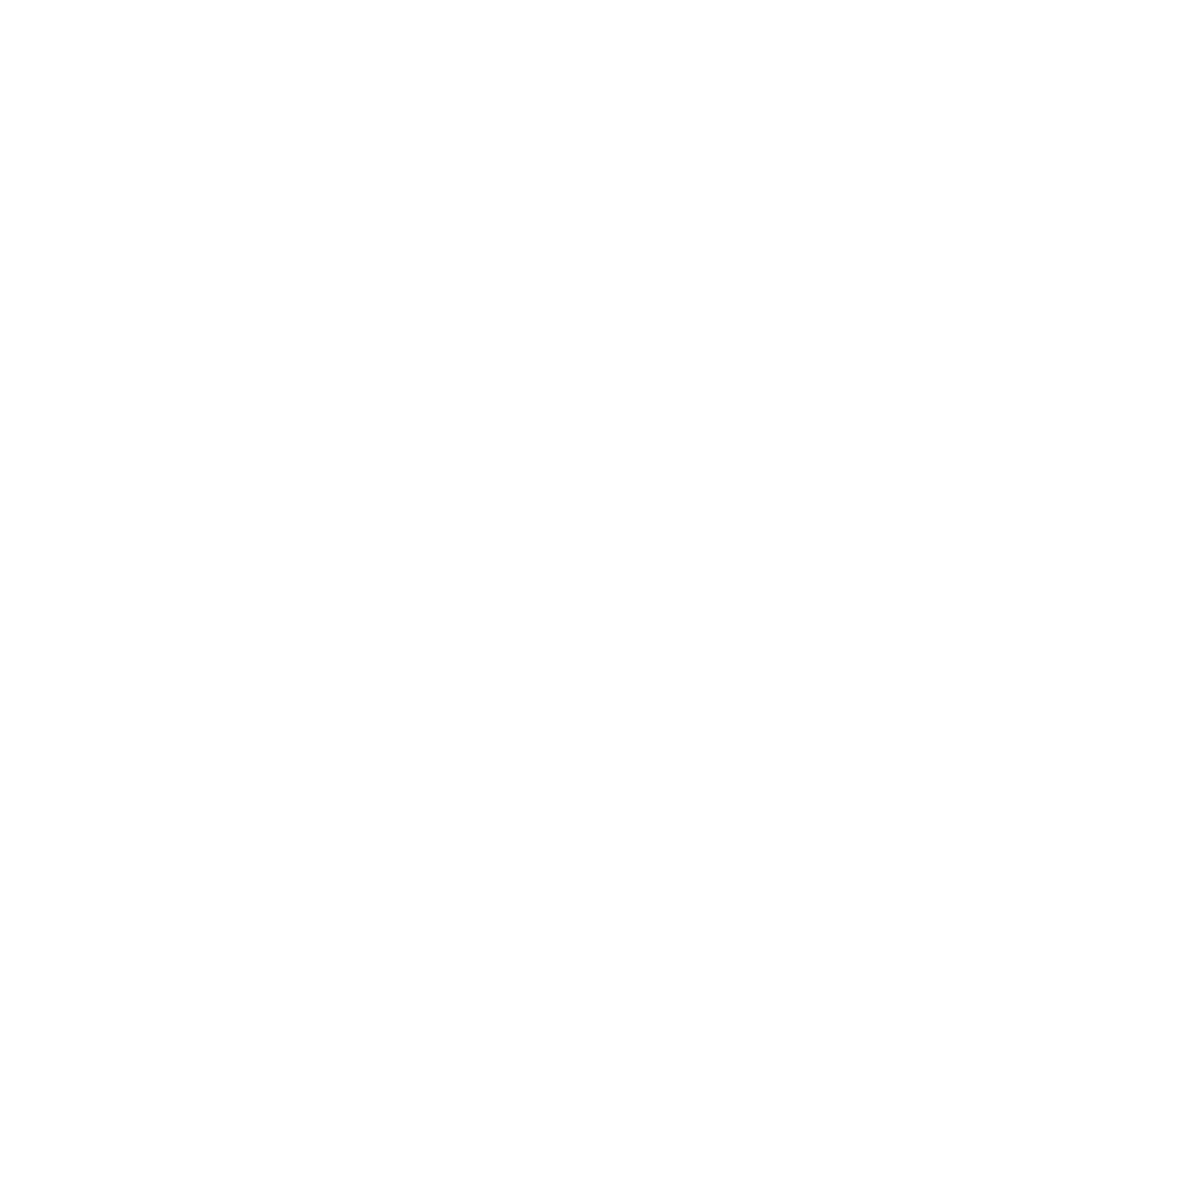

In [14]:
clin = list(df.columns[0:11])
clin.append(df.columns[33])

histo1 = list(df.columns[11:22])
histo2 = list(df.columns[22:33])

set_of_cols = [clin, histo1, histo2]
corr_title = ['Clincal Features', 'Histopathological Set 1', 'Histopathological Set 2']

# %matplotlib notebook
for col, ttl in zip(set_of_cols, corr_title):
    pearsoncorr = df[col].corr(method='pearson') #<- correlation matrix
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(pearsoncorr, 
                xticklabels=pearsoncorr.columns,
                yticklabels=pearsoncorr.columns,
                cmap='RdBu_r',
                annot=True,
                linewidth=0.5,
                ax=ax)
    plt.yticks(rotation=30)
    plt.xticks(rotation=30, ha='right')
    plt.title(ttl)
    fig.subplots_adjust(left=0.15, right=0.95, bottom=0.2)
pass;

- Two pairs of clinical features are correlated:
    - Oral mucosal involvement <> Polygonal Papules
    - Scalp involvement <> Knee and Elbow involvement
- Lots of correlated histopathological features:
    - Exocytosis <> 3 features
    - Parakeratosis <> 3 features
    - Clubbing of the rete ridges <> 2 features
    - Elongation of the rete ridges <> 1 features
    - Focal hypergranulosis <> 3 features
    - Vacuolisation and damage of basal layer <> 3 features
    - Saw-tooth appearance of retes <> 3 features
    - Perifollicular parakeratosis <> Follicular horn plug
    - Band-like infiltrate <> 3 features

<IPython.core.display.Javascript object>


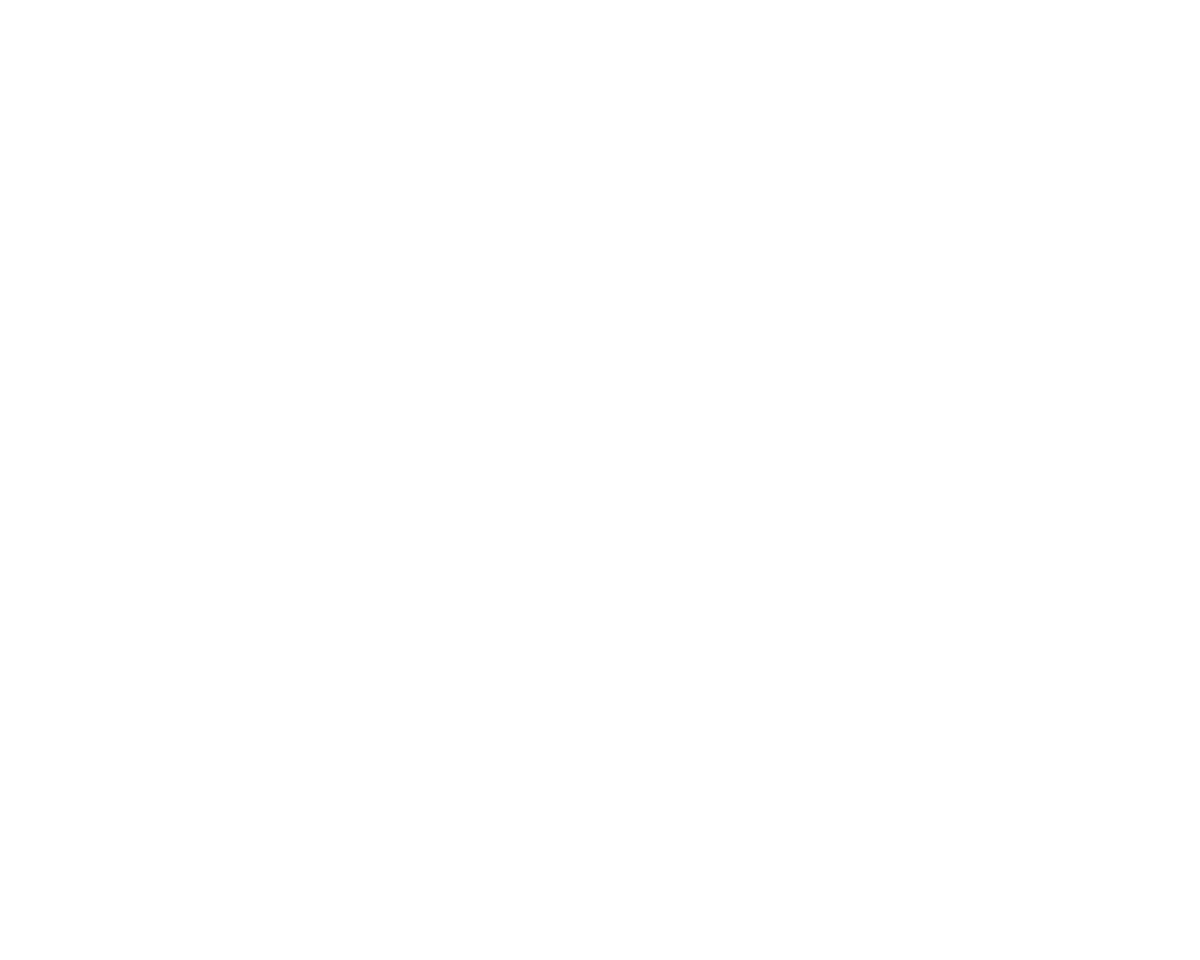

In [15]:
pearsoncorr = df.iloc[:, 0:33].corr(method='pearson') #<- correlation matrix
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
#             annot=True,
            linewidth=0.5,
            ax=ax)
plt.yticks(rotation=30)
plt.xticks(rotation=30, ha='right')
plt.title('Correlations of Clincal and Histopathological Features')
plt.ylabel(None)
ax.tick_params(axis='both', labelsize=8)
fig.subplots_adjust(left=0.25, right=1, bottom=0.2);

Given the moderate to high correlations between some features, it makes sense to group them into smaller number of factors using PCA, then visualize the K-Means clusters using the most important factors (principal components).

### Train/Test Split
- Use training set as training set and validation set in cross validation
- Use test set as evaluation set for model evaluation

In [16]:
#normalized features - all features range 0-3 except for age
X = df.iloc[:, :-2]
y = df.iloc[:, -2]
# y = y.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = df['Class_Code'], random_state=0)

#Check target value distribution in train and test sets
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)
X_train.shape, y_train.shape
X_test.shape, y_test.shape

1    0.304688
3    0.195312
2    0.167969
5    0.144531
4    0.132812
6    0.054688
Name: Class_Code, dtype: float64

1    0.309091
3    0.200000
2    0.163636
5    0.136364
4    0.136364
6    0.054545
Name: Class_Code, dtype: float64

((256, 34), (256,))

((110, 34), (110,))

In [17]:
#Prepare Pipeline
scoring = {'accuracy': make_scorer(accuracy_score),
           'auc' : make_scorer(roc_auc_score, multi_class = 'ovr', average = 'macro', needs_proba=True),
#            'auc_wt' : make_scorer(roc_auc_score, multi_class = 'ovr', average = 'weighted', needs_proba=True),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1_macro': make_scorer(f1_score, average = 'macro'),
           'cohen_kappa': make_scorer(cohen_kappa_score)
          }

def pipeline(classifier_name, classifier):
    # Impute missing values with median
    imp = SimpleImputer(strategy = 'median')

    # Scale variables -> All variables have values ranged 0 - 3 except for Age
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    
    if classifier_name in ['logistic', 'svc']:  #scale features for distance based algorithms
        return Pipeline(steps=[('impute', imp), ('scale', scaler), (classifier_name, classifier)], verbose=0)
    else:                                       #skip scaling for tree based algorithms
        return Pipeline(steps=[('impute', imp), (classifier_name, classifier)], verbose=0)
    # pipe.get_params().keys()

In [18]:
# For refit scorer, if same f1 score, pick the highest accuracy score, then AUC
def best_f1_acc_auc(cv_results):
    rank_cols = [key for key in cv_results.keys() if 'rank_test_' in key]
    k = pd.DataFrame(cv_results)[rank_cols]
    best_idx = k.sort_values(by=['rank_test_f1_macro', 'rank_test_accuracy', 'rank_test_auc']).index[0]
    return best_idx


# refit_score = 'f1_macro'

refit_score = best_f1_acc_auc

cv = 5

In [19]:
#Model Validation and Evaluation
def model_val_eval(model, algorithm_name):

    #Fit model to training set
    if algorithm_name == 'XGBoost':  # Adjust class imbalance by sample weights for gradient boost algorithms
            model.fit(X_train, y_train, XGB__sample_weight=w_array)
    if algorithm_name == 'Gradient Boosting':  # Adjust class imbalance by sample weights for gradient boost algorithms
            model.fit(X_train, y_train, gb__sample_weight=w_array)
    else: model.fit(X_train, y_train)         # Adjust class imbalance by class weights for all other algorithms
    
    #Cross validation results
    if algorithm_name == 'Dummy Classifier':
        scores = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
        #if want to calculate f1-score, macro averaged:
        # [p*r*2/(p+r) for p,r in zip(scores['test_precision'], scores['test_recall'])]

        # 
       
        val_results = pd.Series([np.mean(val) for val in scores.values()],
                                  index=['mean_{}'.format(k) for k in scores.keys()])[2:]

    if algorithm_name != 'Dummy Classifier':
        val_results = pd.DataFrame(model.cv_results_).loc[model.best_index_, ['mean_test_accuracy',
                                                                              'mean_test_auc', 
#                                                                               'mean_test_auc_wt',
                                                                              'mean_test_precision',
                                                                              'mean_test_recall', 
                                                                              'mean_test_f1_macro',
                                                                              'mean_test_cohen_kappa']]

    print('Model Validation Results using Development Set for {}:\n'.format(algorithm_name))
    print(val_results, '\n')
    
    if algorithm_name != 'Dummy Classifier':
        print("Best Estimator: \n{}\n".format(model.best_estimator_))
        print("Best Parameters: \n{}\n".format(model.best_params_))
#         print("Best Test {} score: \n{}\n".format(refit_score, model.best_score_))
        
    
    #Fit model with best parameters to test set
    y_pred= model.predict(X_test)
    
    y_scores = model.predict_proba(X_test)  #Can't use predict_proba for SVM
    
    
    #Evaluate model
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_scores, multi_class = 'ovr', average = 'macro')
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
#     auc_wt = roc_auc_score(y_test, y_scores, multi_class = 'ovr', average = 'weighted')
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                 columns=['Pred_{}'.format(x) for x in np.unique(y_test)],
                 index=['y_{}'.format(x) for x in np.unique(y_test)])
    
    print('\nModel Evaluation Results using Test Set for {}:\n\n'.format(algorithm_name))
    print('Confusion Matrix:\n', cm, '\n\n')
    print(classification_report(y_test, y_pred, zero_division=0, digits=5))
    print('Test set accuracy score: {}'.format(acc))
    print('Test set AUC: {}'.format(auc))
    print("Test set Cohen's Kappa score: {}".format(kappa))
    print('Test set f1-macro score: {}'.format(f1))
#     print('Test set AUC, weighted: {}'.format(auc_wt))
    return (acc, auc, kappa, f1, y_pred, y_scores)

### Dummy Classifier as Baseline Model

In [20]:
dummy_majority = DummyClassifier(strategy = 'most_frequent')
pipe = pipeline('dummy', dummy_majority)

# scores = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
# # scores
# #if want to calculate f1-score, macro averaged:
# # [p*r*2/(p+r) for p,r in zip(scores['test_precision'], scores['test_recall'])]

# # print('Model Evaluation Results using Test Set for {}:\n\n'.format(algorithm_name))
# print('Model Validation Results using Development Set for {}:\n'.format('Dummy Classifier'))
# pd.Series([np.mean(val) for val in scores.values()],
#           index=['mean_{}'.format(k) for k in scores.keys()])[2:]

test_results_dummy = model_val_eval(pipe, 'Dummy Classifier')

Model Validation Results using Development Set for Dummy Classifier:

mean_test_accuracy       0.304676
mean_test_auc            0.500000
mean_test_precision      0.050779
mean_test_recall         0.166667
mean_test_f1_macro       0.077830
mean_test_cohen_kappa    0.000000
dtype: float64 


Model Evaluation Results using Test Set for Dummy Classifier:


Confusion Matrix:
      Pred_1  Pred_2  Pred_3  Pred_4  Pred_5  Pred_6
y_1      34       0       0       0       0       0
y_2      18       0       0       0       0       0
y_3      22       0       0       0       0       0
y_4      15       0       0       0       0       0
y_5      15       0       0       0       0       0
y_6       6       0       0       0       0       0 


              precision    recall  f1-score   support

           1    0.30909   1.00000   0.47222        34
           2    0.00000   0.00000   0.00000        18
           3    0.00000   0.00000   0.00000        22
           4    0.00000   0.00000   0.000

### Set Class Weight as Hyperparameter for Grid Search
- Due to imbalanced classes, need to set class_weight = 'balanced' to penalize more for misclassifing the minority classes
- But also want to explore other class weight options

In [21]:
# Class_Code  Class                   
# 1           psoriasis                   112
# 2           seboreic dermatitis          61
# 3           lichen planus                72
# 4           pityriasis rosea             49
# 5           cronic dermatitis            52
# 6           pityriasis rubra pilaris     20

# Create weight values for class_weight parameter = n/(2*nk) where k = class label
n_classes = df['Class_Code'].nunique()
wt = 1/df['Class_Code'].value_counts().sort_index()*len(df)/n_classes
# wt

wt_pct = wt/np.sum(wt)
# wt_pct
# dict(zip(wt.index, wt_pct))

wt_pct.values


# Found that wt_pct = wt_norm = normalized 'balanced' class_weight:
from sklearn.utils import class_weight
# k = class_weight.compute_class_weight('balanced', np.unique(df['Class_Code']), df['Class_Code'])
# k/k.sum()

k_train = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# k_train/k_train.sum()

# k_test = class_weight.compute_class_weight('balanced', np.unique(y_test), y_test)
# k_test/k_test.sum()


#balanced class weights
wt = dict(zip(np.unique(y_train), k_train))
wt

#normalized class weights
wt_norm = dict(zip(np.unique(y_train), k_train/k_train.sum()))
wt_norm

#weight relative to classes should be the same
list(wt.values())/wt[6]
list(wt_norm.values())/wt_norm[6]

array([0.0692944 , 0.12722905, 0.10779128, 0.15838719, 0.14924947,
       0.38804861])

{1: 0.5470085470085471,
 2: 0.9922480620155039,
 3: 0.8533333333333334,
 4: 1.2549019607843137,
 5: 1.1531531531531531,
 6: 3.0476190476190474}

{1: 0.06969803000586539,
 2: 0.1264289846618023,
 3: 0.10872892680914999,
 4: 0.15989548060169115,
 5: 0.146930982174527,
 6: 0.38831759574696423}

array([0.17948718, 0.3255814 , 0.28      , 0.41176471, 0.37837838,
       1.        ])

array([0.17948718, 0.3255814 , 0.28      , 0.41176471, 0.37837838,
       1.        ])

### Logistic Regression Classifier

In [22]:
for w, w_type in zip(['balanced', wt, wt_norm], ['balanced', 'calculated balanced', 'normalized']):
    logistic = LogisticRegression(random_state=0, max_iter=1000, solver='saga', penalty='l2', multi_class='multinomial',
                             class_weight = w)

    def pipeline(classifier_name, classifier):

        imp = SimpleImputer(strategy = 'median')
        scaler = MinMaxScaler()
        return Pipeline(steps=[('impute', imp), ('scale', scaler), (classifier_name, classifier)], verbose=0)

    pipe = pipeline('logistic', logistic)

    grid_values = {'logistic__C': np.arange(1,11)} #np.logspace(-4, 3, 8)}

    grid_lr = GridSearchCV(estimator = pipe, param_grid = grid_values, 
                           scoring = scoring,
                           cv = 5, return_train_score=True,
                           n_jobs = -1, refit='auc')
    grid_lr.fit(X_train, y_train)
    print('Best AUC for {} class weights: {}'.format(w_type, grid_lr.best_score_))
    print('Best Parameter for {} class weights: {}'.format(w_type, grid_lr.best_params_))

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('scale',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                    

Best AUC for balanced class weights: 0.9998236331569664
Best Parameter for balanced class weights: {'logistic__C': 1}


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('scale',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight={1: 0.5470085470085471,
                                        

Best AUC for calculated balanced class weights: 0.9998236331569664
Best Parameter for calculated balanced class weights: {'logistic__C': 1}


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('scale',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight={1: 0.06969803000586539,
                                       

Best AUC for normalized class weights: 0.9998236331569664
Best Parameter for normalized class weights: {'logistic__C': 8}


In [23]:
logistic = LogisticRegression(random_state=0, max_iter=1000, solver='saga', penalty='l2', multi_class='multinomial')

pipe = pipeline('logistic', logistic)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
C = sorted(np.append(np.logspace(-4, 3, 8), np.arange(2,10)))
# [0.0001,  0.001,  0.01,  0.1,  1.0,
#  2.0,  3.0,  4.0,  5.0,  6.0,
#  7.0,  8.0,  9.0,  10.0,  100.0,  1000.0]
           
grid_values = {
              'logistic__C': C,
              'logistic__class_weight': ['balanced', wt_norm]
                }
grid_lr = GridSearchCV(estimator = pipe, param_grid = grid_values, scoring = scoring, cv = cv, return_train_score=True,
                       n_jobs = -1, refit= refit_score)

test_results_lr = model_val_eval(grid_lr, 'Logistic Regression')

# pd.DataFrame(grid_lr.cv_results_).loc[grid_lr.best_index_,
#                                       ['param_logistic__class_weight', 'param_logistic__C',
#                                                       'mean_test_accuracy', 'mean_train_accuracy', 'rank_test_accuracy',
#                                                       'mean_test_auc', 'mean_train_auc', 'rank_test_auc',
#                                                       'mean_test_auc_wt', 'mean_train_auc_wt', 'rank_test_auc_wt',
#                                                       'mean_test_precision', 'mean_train_precision',
#                                                       'mean_test_recall', 'mean_train_recall',
#                                                       'mean_test_f1_macro', 'mean_train_f1_macro']]

Model Validation Results using Development Set for Logistic Regression:

mean_test_accuracy       0.972624
mean_test_auc            0.999078
mean_test_precision      0.973981
mean_test_recall         0.972553
mean_test_f1_macro        0.96957
mean_test_cohen_kappa    0.965785
Name: 6, dtype: object 

Best Estimator: 
Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('logistic',
                 LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='multinomial', n_jobs=None,
                                    

### Plot top features for each class
- visualize_coefficients from https://github.com/amueller/mglearn/blob/master/mglearn/tools.py

In [24]:
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    
    # plot them
    plt.figure(figsize=(10, 5))
    colors = ['red' if c < 0 else 'blue'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.4)
    plt.xticks(np.arange(0, 2 * 6),
               feature_names[interesting_coefficients], rotation=30,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")
    plt.title('Class {}'.format(i+1))

<IPython.core.display.Javascript object>


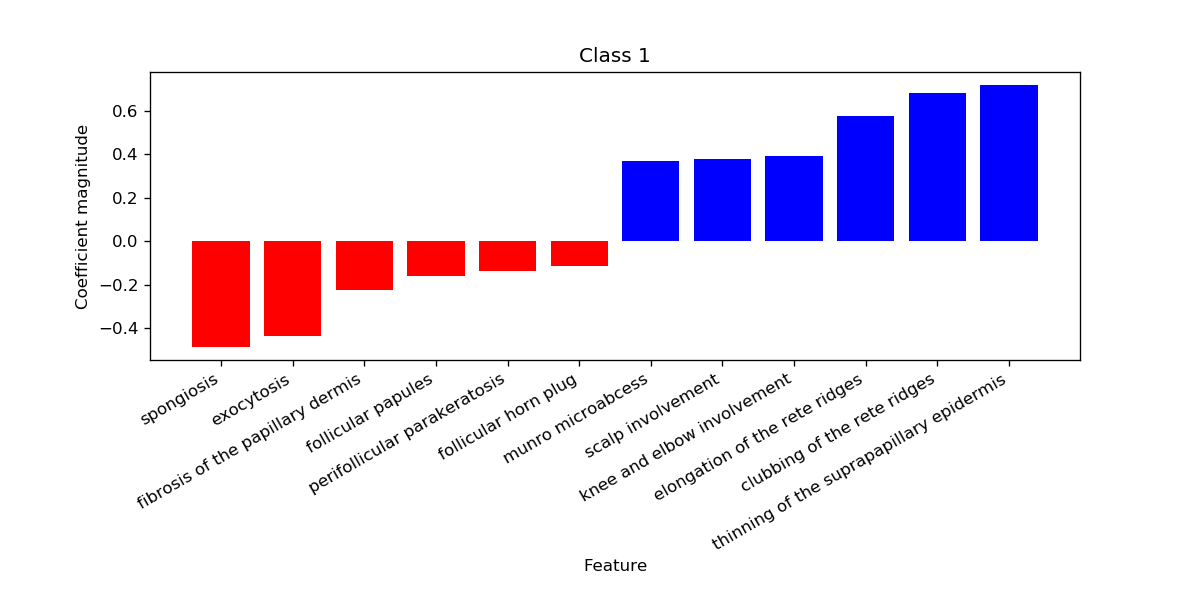

<IPython.core.display.Javascript object>


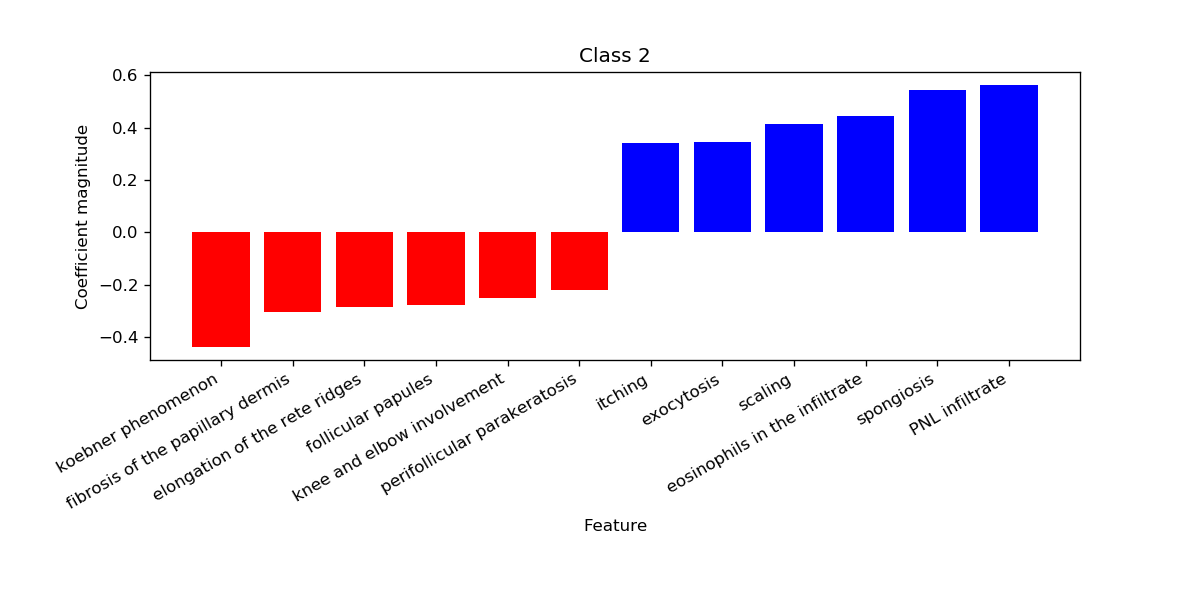

<IPython.core.display.Javascript object>


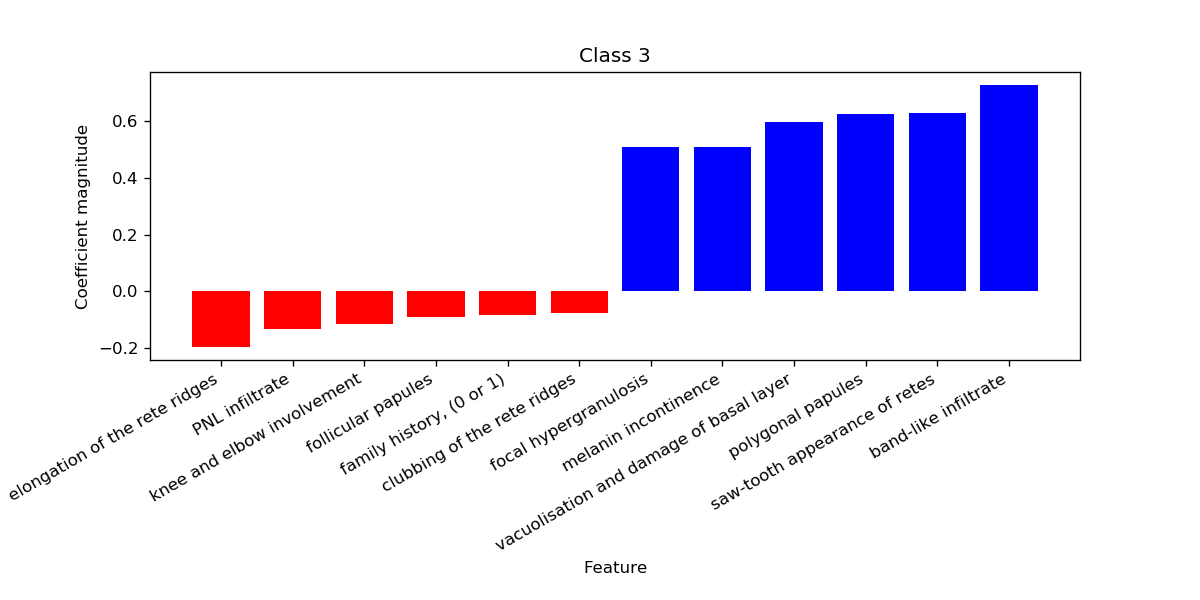

<IPython.core.display.Javascript object>


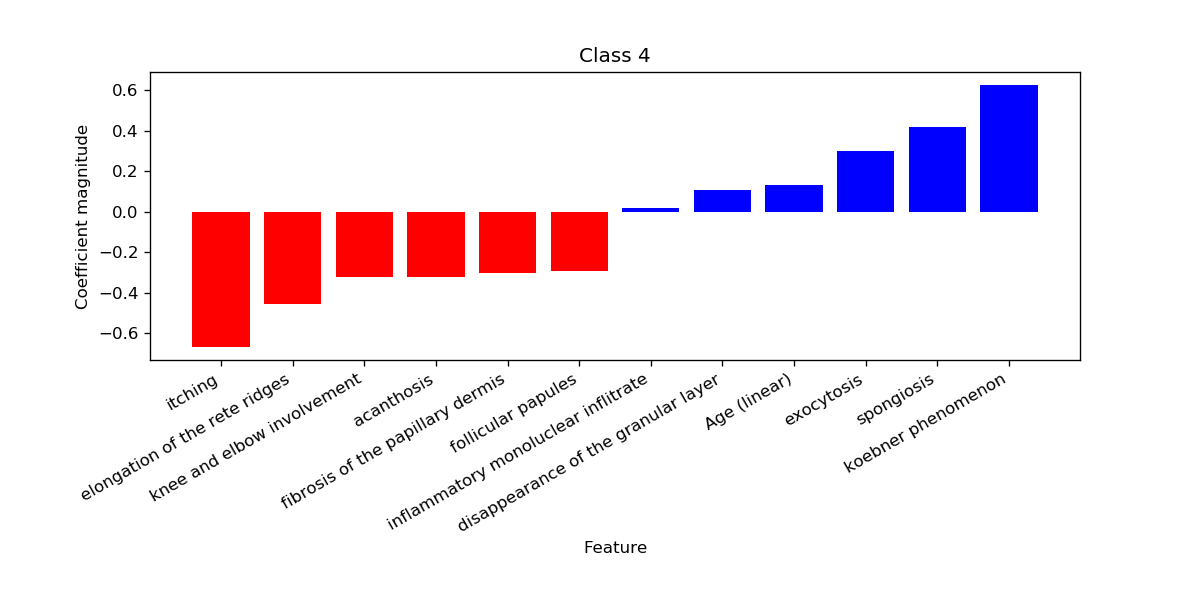

<IPython.core.display.Javascript object>


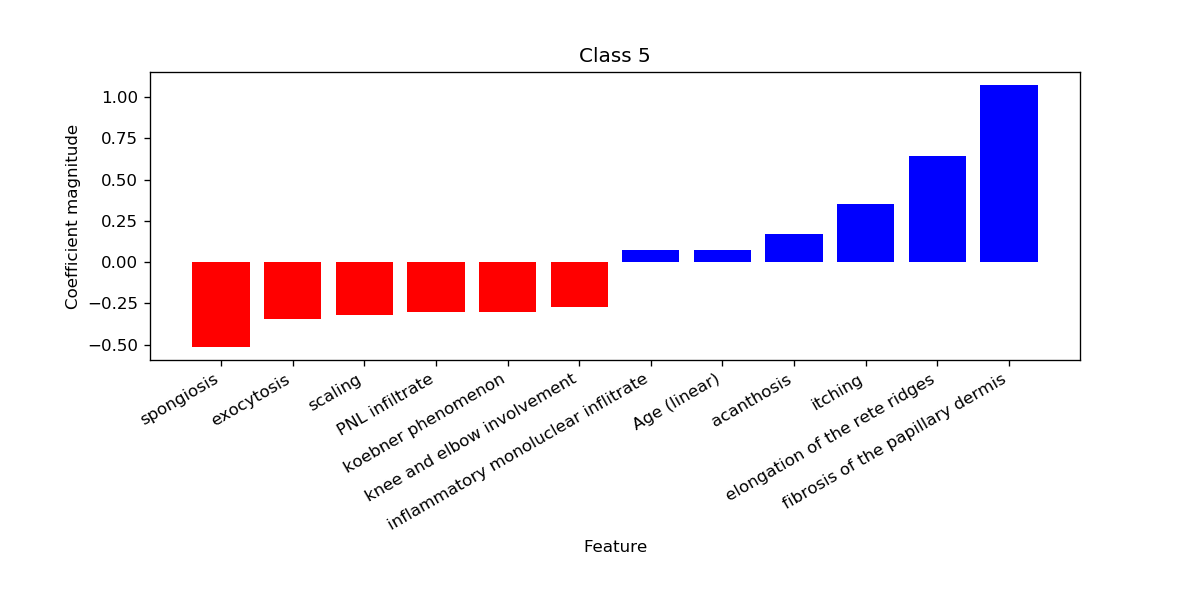

<IPython.core.display.Javascript object>


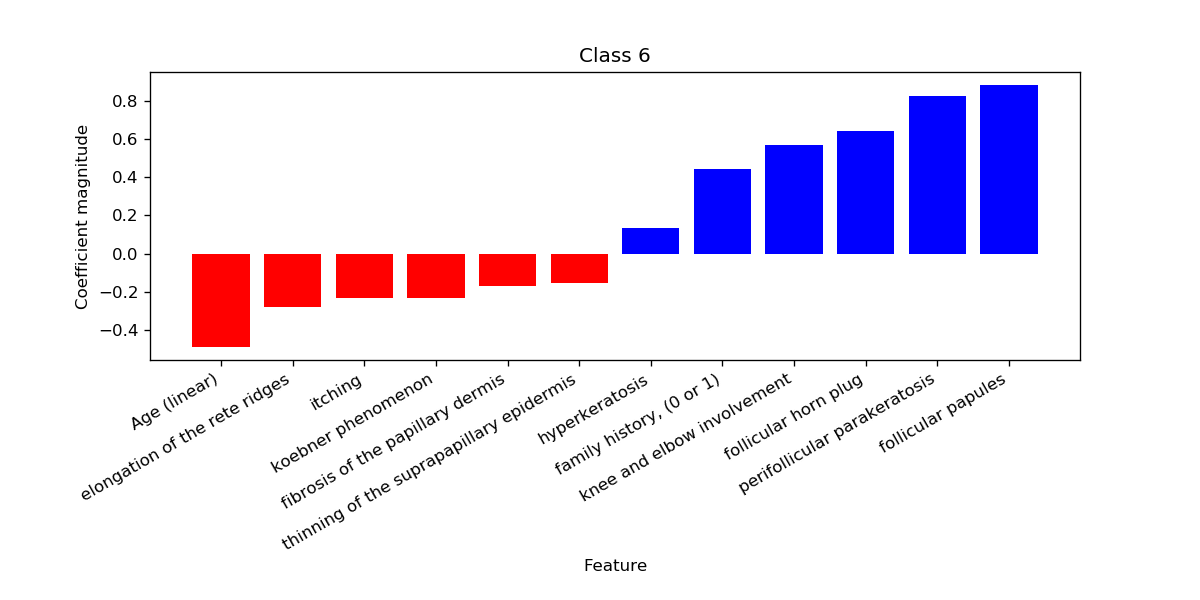

In [48]:
for i in range(y_train.nunique()):
    k = pd.DataFrame(index=df.columns[:-2], columns=['coef'],
                data=grid_lr.best_estimator_.named_steps['logistic'].coef_[i]).sort_values(by='coef')
    
    top_coef = k.head(6).append(k.tail(6))
    visualize_coefficients(grid_lr.best_estimator_.named_steps['logistic'].coef_[i],
                                         df.columns[:-2],
                                        n_top_features=6)

### SVM

In [26]:
svc = SVC(kernel='rbf', random_state=0, max_iter=500, probability=True)

pipe = pipeline('svc', svc)


# Parameters of pipelines can be set using ‘__’ separated parameter names:
C = sorted(np.append(np.logspace(-4, 3, 8), np.arange(2,10)))
grid_values = [{'svc__C': C,
                'svc__class_weight': [None, 'balanced', wt_norm],
                'svc__kernel' : ['linear']
               },
               {'svc__C': C,
                'svc__class_weight': [None, 'balanced', wt_norm],
                'svc__kernel' : ['rbf'],
                'svc__gamma': ['auto']+C
               }]


grid_sv = GridSearchCV(estimator = pipe, param_grid = grid_values, scoring = scoring, cv = cv, return_train_score=True
                       ,n_jobs = -1, refit = refit_score)

test_results_sv = model_val_eval(grid_sv, 'SVC')

# pd.DataFrame(grid_lr.cv_results_).loc[grid_lr.best_index_,
#                                       ['param_logistic__class_weight', 'param_logistic__C',
#                                                       'mean_test_accuracy', 'mean_train_accuracy', 'rank_test_accuracy',
#                                                       'mean_test_auc', 'mean_train_auc', 'rank_test_auc',
#                                                       'mean_test_auc_wt', 'mean_train_auc_wt', 'rank_test_auc_wt',
#                                                       'mean_test_precision', 'mean_train_precision',
#                                                       'mean_test_recall', 'mean_train_recall',
#                                                       'mean_test_f1_macro', 'mean_train_f1_macro']]

Model Validation Results using Development Set for SVC:

mean_test_accuracy       0.984314
mean_test_auc            0.999411
mean_test_precision      0.985844
mean_test_recall         0.982011
mean_test_f1_macro       0.982268
mean_test_cohen_kappa    0.980377
Name: 34, dtype: object 

Best Estimator: 
Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svc',
                 SVC(C=8.0, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='linear', max_iter=500, probability=True,
                     random_state=0, shrinking=True, tol=0.001,
                     verb

### Random Forest Classifier

In [35]:
rf = RandomForestClassifier(random_state=0,
                           n_estimators=200,
                           max_depth=6,
                           max_features=6,
                           class_weight='balanced',
                           n_jobs=-1)

pipe = pipeline('rf', rf)


# Parameters of pipelines can be set using ‘__’ separated parameter names:
grid_values = {
#                     'rf__n_estimators': [50, 100, 200, 300, 400],
#                    'rf__max_depth' : [3, 4, 5, 6, 7]
    
# 1st search results:   0.971527
# {'rf__max_depth': 5, 'rf__n_estimators': 200}
    
#                  'rf__class_weight': [None, 'balanced', wt_norm],

    
# 2nd search results: 0.983688
#{'rf__class_weight': 'balanced'}
    
#                    'rf__max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    
# 3rd search reults: 0.983688 
#{rf__max_features: 4}    
    
                 'rf__n_estimators': [150, 175, 200, 225, 250, 275, 300],
                 'rf__max_depth' : [3, 4, 5, 6, 7, 8],
                 'rf__max_features': [2, 3, 4, 5, 6, 7],
    
# Final results: 0.986712
# {'rf__max_depth': 6, 'rf__max_features': 6, 'rf__n_estimators': 200}    
             }



grid_rf = GridSearchCV(estimator = pipe, param_grid = grid_values, scoring = scoring, cv = cv, return_train_score=True
                       ,n_jobs = -1, refit = refit_score)

test_results_rf = model_val_eval(grid_rf, 'Random Forest')


FI = grid_rf.best_estimator_.named_steps['rf'].feature_importances_
pd.Series(FI, name='Feature_Importance', index=df.columns[:-2]).sort_values(ascending=False)

Model Validation Results using Development Set for Random Forest:

mean_test_accuracy       0.988311
mean_test_auc            0.999222
mean_test_precision      0.987738
mean_test_recall         0.987368
mean_test_f1_macro       0.986712
mean_test_cohen_kappa    0.985382
Name: 156, dtype: object 

Best Estimator: 
Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=6,
                                        max_features=6, max_leaf_nodes=None,
                                        max_samples=None,
   

fibrosis of the papillary dermis            0.114272
thinning of the suprapapillary epidermis    0.072420
perifollicular parakeratosis                0.069955
koebner phenomenon                          0.056373
elongation of the rete ridges               0.054920
follicular horn plug                        0.048213
clubbing of the rete ridges                 0.047200
vacuolisation and damage of basal layer     0.045514
band-like infiltrate                        0.042080
follicular papules                          0.041522
Age (linear)                                0.037869
polygonal papules                           0.037811
spongiosis                                  0.037495
saw-tooth appearance of retes               0.036914
knee and elbow involvement                  0.035645
melanin incontinence                        0.030589
exocytosis                                  0.024205
itching                                     0.023223
scaling                                     0.

### Gradient Boost Decision Trees

In [28]:
# Since there is not class_weight option in Gradient Boosting and XGBoost
# Use sample_weight to balance multi-class sizes by appling class weight to each data instance


# w_array = y_train.map(wt_norm) #not sure why, but using unnormalized weights get higher AUC
w_array = y_train.map(wt)
set(zip(y_train,w_array))
w_array = w_array.values

{(1, 0.5470085470085471),
 (2, 0.9922480620155039),
 (3, 0.8533333333333334),
 (4, 1.2549019607843137),
 (5, 1.1531531531531531),
 (6, 3.0476190476190474)}

In [53]:
gb = GradientBoostingClassifier(random_state=0,
                               n_estimators = 40,
                               learning_rate = 0.05,
                               max_depth = 10,
                               max_features = 3,
                               ccp_alpha = 0,
                               subsample = 1,
                               n_iter_no_change = 50)

pipe = pipeline('gb', gb)

alpha = [0]
alpha.extend([x*y for y in np.logspace(-3,0, 4)  for x in [5, 10]])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
grid_values = {
#     'gb__n_estimators': [50, 100, 150, 200, 250, 300],
#     'gb__learning_rate' : [0.025, 0.05,0.075, 0.1, 0.15]
    
# 1st search results: 
# {'gb__learning_rate': 0.15, 'gb__n_estimators': 100}
    
# #                  'gb__class_weight': [None, 'balanced', wt_norm], <- no such parameter
#                  'gb__max_features': [7, 8, 9, 10, 12, 14], #initial 10
#                  'gb__max_depth' : [5, 6, 7, 8, 9]   # initial 7
 
# 2nd search results:
# {'gb__max_depth': 9, 'gb__max_features': 14}   
#                  'gb__max_features': [13, 14, 15, 16, 17, 18], #initial 14
#                  'gb__max_depth' : [8, 9, 10, 11]   # initial 9
    
# 3nd search results:
# {'gb__max_depth': 9, 'gb__max_features': 13}   
    
#     'gb__n_estimators': [50, 75, 100],  #initial 100
#     'gb__learning_rate' : [0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225],  #initial 0.15
#     'gb__max_features': [10, 11, 12, 13, 14, 15, 16], #initial 10
#     'gb__max_depth' : [6, 7, 8, 9, 10, 11]   # initial 7
    
# 4th searh results:
# {'gb__learning_rate': 0.225, 'gb__max_depth': 11, 'gb__max_features': 10, 'gb__n_estimators': 50}
#     'gb__n_estimators': [40, 50, 60, 300, 400, 500],  #initial 100
#     'gb__learning_rate' : [0.025, 0.05, 0.075, 0.1, 0.15,  0.2, 0.225, 0.25],  #initial 0.15
#     'gb__max_features': [5,  7,  9, 11, 13, 15], #initial 10
#     'gb__max_depth' : [6, 7, 8, 9, 10, 11, 12]   # initial 7
    
# 5th search results:
# {'gb__learning_rate': 0.2, 'gb__max_depth': 9, 'gb__max_features': 9, 'gb__n_estimators': 40}

#     'gb__ccp_alpha': alpha
    

#     {'gb__ccp_alpha': 0}
# results: 0.983688
    
# Tune all parameters again
#         'gb__n_estimators': [30, 40, 50, 60, 70, 80],  #initial 100
#         'gb__learning_rate' : [0.05, 0.1, 0.15,  0.2, 0.25],  #initial 0.15
#         'gb__max_features': [3, 5,  7,  9, 11, 13], #initial 10
#         'gb__max_depth' : [5, 6, 7, 8, 9, 10]   # initial 7
    
# Search results: 0.991031 
# {'gb__learning_rate': 0.05, 'gb__max_depth': 10, 'gb__max_features': 3, 'gb__n_estimators': 40}
        'gb__subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]
    
# Final results: 0.991031
#     'gb__subsample': 1.0
}
    

grid_gb = GridSearchCV(estimator = pipe, param_grid = grid_values, scoring = scoring, cv = cv, return_train_score=True
                       ,n_jobs = -1, refit = refit_score)

test_results_gb = model_val_eval(grid_gb, 'Gradient Boosting')


FI = grid_gb.best_estimator_.named_steps['gb'].feature_importances_
pd.Series(FI, name='Feature_Importance', index=df.columns[:-2]).sort_values(ascending=False)

Model Validation Results using Development Set for Gradient Boosting:

mean_test_accuracy       0.992232
mean_test_auc            0.999599
mean_test_precision      0.991071
mean_test_recall          0.99213
mean_test_f1_macro       0.991031
mean_test_cohen_kappa    0.990271
Name: 6, dtype: object 

Best Estimator: 
Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('gb',
                 GradientBoostingClassifier(ccp_alpha=0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.05, loss='deviance',
                                            max_depth=10, max_features=3,
                                            max_le

fibrosis of the papillary dermis            0.060087
thinning of the suprapapillary epidermis    0.058589
koebner phenomenon                          0.058255
polygonal papules                           0.056787
follicular horn plug                        0.050186
follicular papules                          0.044158
elongation of the rete ridges               0.043422
spongiosis                                  0.043016
knee and elbow involvement                  0.041723
band-like infiltrate                        0.039350
PNL infiltrate                              0.037999
exocytosis                                  0.035749
perifollicular parakeratosis                0.032883
scaling                                     0.032340
clubbing of the rete ridges                 0.029589
vacuolisation and damage of basal layer     0.026124
Age (linear)                                0.026088
oral mucosal involvement                    0.025821
melanin incontinence                        0.

<IPython.core.display.Javascript object>


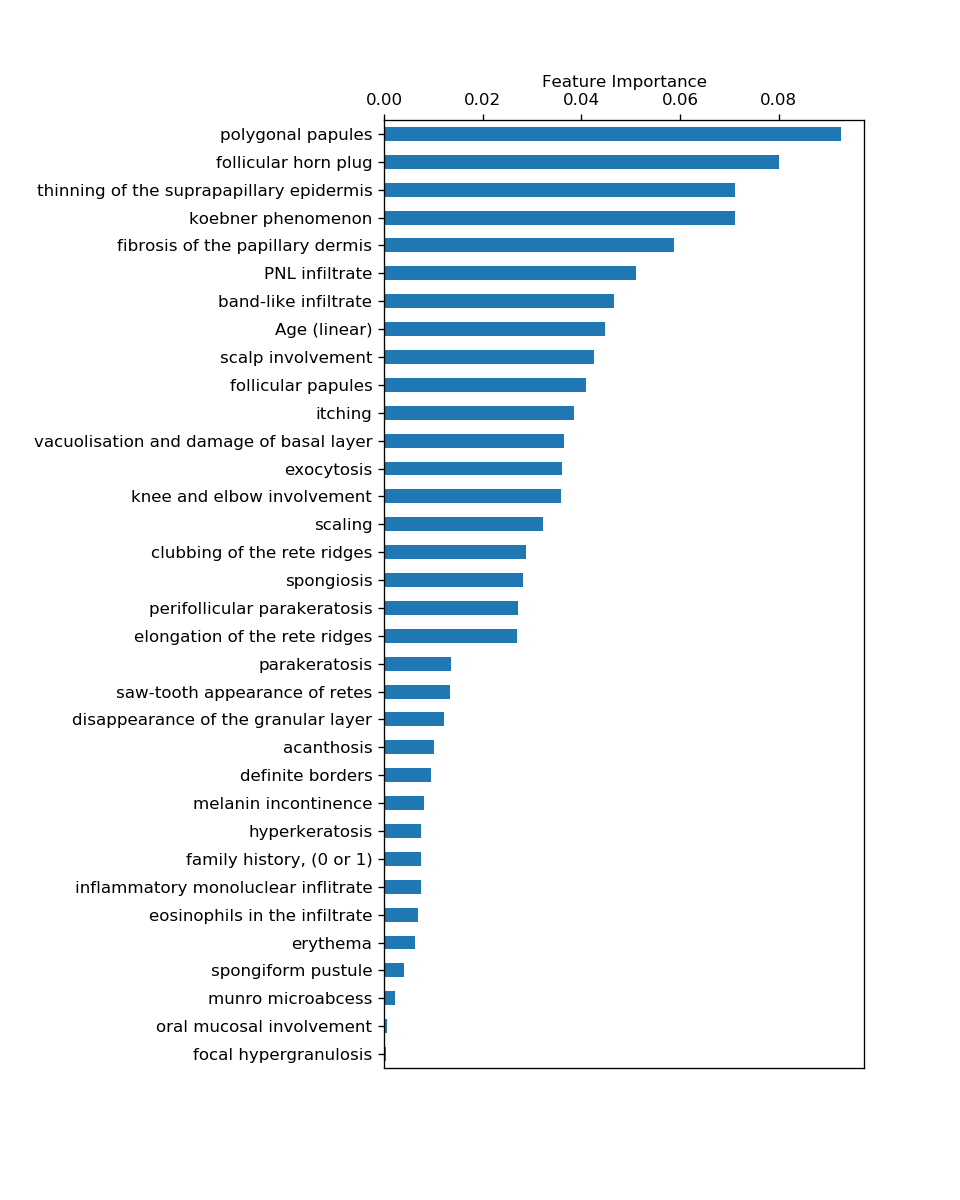

In [37]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,10))
pd.Series(FI, name='Feature_Importance', index=df.columns[:-2]).sort_values(ascending=True).plot.barh()
ax.set_xlabel('Feature Importance')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
fig.subplots_adjust(left=0.4, top = 0.9)
pass;

### XGBoost

### Get N_Estimators using Built-in xgb.cv()
- Will do a gridsearch on n_estimators around this value and range of learning rates


Model Report
Best n_estimators = 175
Train Accuracy: 1.00000
Train AUC Score: 1.00000
Train Kappa Score: 1.00000
Train F1-macro Score: 1.00000
Test Accuracy: 0.95455
Test AUC Score: 0.99705
Test Kappa Score: 0.94295
Test F1-macro Score: 0.94777


<IPython.core.display.Javascript object>


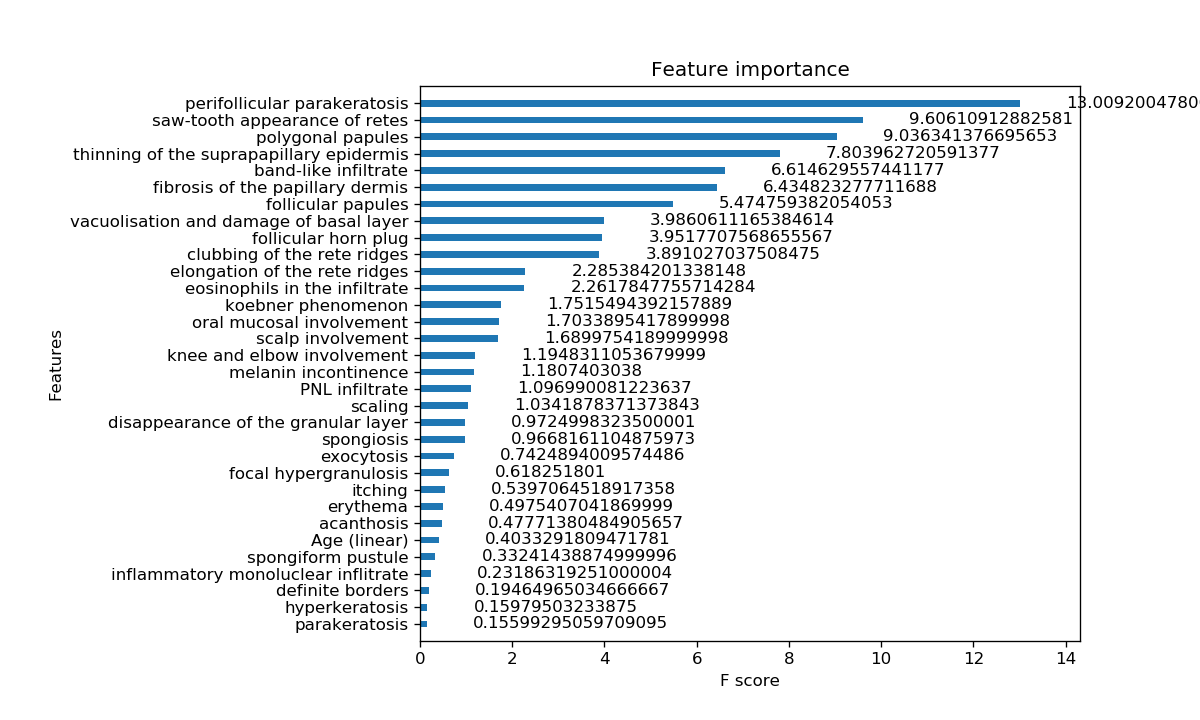

In [38]:
alg = xgb.XGBClassifier(random_state=0,
                        learning_rate =0.1,
                        n_estimators=1000,
                        max_depth=5,
                        min_child_weight=1,
                        gamma=0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        colsample_bynode=0.8,
                        objective= 'multi:softprob',
                        nthread=4,
                        # scale_pos_weight=1,
                        num_class=6,
                        seed=0,
                        verbosity=0)

xgb_param = alg.get_xgb_params()

xgtrain = xgb.DMatrix(X_train.values, label=(y_train-1).values)  #minus 1 bc label must be in [0, num_class)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=5,
                    metrics='mlogloss', #can't use auc for multiclass, another option = merror
                      early_stopping_rounds=50, verbose_eval=False)



# cvresult
alg.set_params(n_estimators=cvresult.shape[0])

# #Fit the algorithm on the data
alg.fit(X_train, y_train, eval_metric='mlogloss', sample_weight=w_array)

#Predict training set:
train_pred = alg.predict(X_train)
train_prob = alg.predict_proba(X_train)

test_pred = alg.predict(X_test)
test_prob = alg.predict_proba(X_test)


#Print model report:
print("\nModel Report")
print('Best n_estimators = {}'.format(alg.n_estimators))
print('Train Accuracy: {:.5f}'.format(accuracy_score(y_train, train_pred)))
print('Train AUC Score: {:.5f}'.format(roc_auc_score(y_train, train_prob, multi_class = 'ovr', average = 'macro')))
print('Train Kappa Score: {:.5f}'.format(cohen_kappa_score(y_train, train_pred)))
print('Train F1-macro Score: {:.5f}'.format(f1_score(y_train, train_pred, average = 'macro')))

print('Test Accuracy: {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Test AUC Score: {:.5f}'.format(roc_auc_score(y_test, test_prob, multi_class = 'ovr', average = 'macro')))
print('Test Kappa Score: {:.5f}'.format(cohen_kappa_score(y_test, test_pred)))
print('Test F1-macro Score: {:.5f}'.format(f1_score(y_test, test_pred, average = 'macro')))      

#Plot feature importance
%matplotlib notebook
fig, ax1 = plt.subplots(figsize=(10,6))
xgb.plot_importance(alg, height = 0.4, grid = False, ax=ax1, importance_type='gain')
fig.subplots_adjust(left = 0.35);


In [40]:
# How to get back alg.feature_importances_ (gain based) from plot_importance fscore
# Calculate two types of feature importance:
    # Weight = number of times a feature appears in tree
    # Gain = average gain of splits which use the feature
    # Normalized gain = Proportion of average gain out of sum of average gain
    
#Default feature_importance_ values based on gain values
pd.Series(alg.feature_importances_, index=X_train.columns, name='Feature_Importance').sort_values(ascending=False)

#Calculate different types of feature importance
k = alg.get_booster().trees_to_dataframe()
group = k[k['Feature']!='Leaf'].groupby('Feature').agg(fscore = ('Gain', 'count'),
                                                       feature_importance_gain =  ('Gain', 'mean'))

# Feature importance same as plot_importance(importance_type = 'weight'), default value
group['fscore'].sort_values(ascending=False)

# Feature importance same as classifier.feature_importance_ default = 'gain'
group['feature_importance_gain_norm'] = group['feature_importance_gain']/group['feature_importance_gain'].sum()
group['feature_importance_gain_norm'].sort_values(ascending=False)

# Feature importance same as plot_importance(importance_type = 'gain')
group['feature_importance_gain'].sort_values(ascending=False)

perifollicular parakeratosis                0.144066
saw-tooth appearance of retes               0.106379
polygonal papules                           0.100070
thinning of the suprapapillary epidermis    0.086422
band-like infiltrate                        0.073251
fibrosis of the papillary dermis            0.071260
follicular papules                          0.060628
vacuolisation and damage of basal layer     0.044142
follicular horn plug                        0.043762
clubbing of the rete ridges                 0.043090
elongation of the rete ridges               0.025309
eosinophils in the infiltrate               0.025047
koebner phenomenon                          0.019397
oral mucosal involvement                    0.018864
scalp involvement                           0.018715
knee and elbow involvement                  0.013232
melanin incontinence                        0.013076
PNL infiltrate                              0.012148
scaling                                     0.

Feature
Age (linear)                                270
spongiosis                                  154
itching                                     144
koebner phenomenon                          114
PNL infiltrate                              110
exocytosis                                   98
scaling                                      86
elongation of the rete ridges                81
fibrosis of the papillary dermis             77
clubbing of the rete ridges                  59
thinning of the suprapapillary epidermis     58
parakeratosis                                55
acanthosis                                   53
erythema                                     50
hyperkeratosis                               48
follicular papules                           37
disappearance of the granular layer          36
knee and elbow involvement                   35
band-like infiltrate                         34
saw-tooth appearance of retes                31
perifollicular parakeratosis    

Feature
perifollicular parakeratosis                0.144066
saw-tooth appearance of retes               0.106379
polygonal papules                           0.100070
thinning of the suprapapillary epidermis    0.086422
band-like infiltrate                        0.073251
fibrosis of the papillary dermis            0.071260
follicular papules                          0.060628
vacuolisation and damage of basal layer     0.044142
follicular horn plug                        0.043762
clubbing of the rete ridges                 0.043090
elongation of the rete ridges               0.025309
eosinophils in the infiltrate               0.025047
koebner phenomenon                          0.019397
oral mucosal involvement                    0.018864
scalp involvement                           0.018715
knee and elbow involvement                  0.013232
melanin incontinence                        0.013076
PNL infiltrate                              0.012148
scaling                               

Feature
perifollicular parakeratosis                13.009200
saw-tooth appearance of retes                9.606109
polygonal papules                            9.036341
thinning of the suprapapillary epidermis     7.803963
band-like infiltrate                         6.614630
fibrosis of the papillary dermis             6.434823
follicular papules                           5.474759
vacuolisation and damage of basal layer      3.986061
follicular horn plug                         3.951771
clubbing of the rete ridges                  3.891027
elongation of the rete ridges                2.285384
eosinophils in the infiltrate                2.261785
koebner phenomenon                           1.751549
oral mucosal involvement                     1.703390
scalp involvement                            1.689975
knee and elbow involvement                   1.194831
melanin incontinence                         1.180740
PNL infiltrate                               1.096990
scaling             

In [41]:
# Features with zero gain values don't show in trees_to_dataframe
# Check what they are by copmaring feature names with the original column names
X_train.columns[[ x not in k['Feature'].unique() for x in X_train.columns]]

Index(['family history, (0 or 1)', 'munro microabcess'], dtype='object')

### XGBoost without Imputation

In [42]:
XGB = xgb.XGBClassifier(objective="multi:softprob",
                        random_state=0,
#                        base_score=None, 
                        booster='gbtree',
                        verbosity=0,
                        validate_parameters=True, 
                        tree_method='auto', 
                        n_estimators=175,  #initial input = 175
                        learning_rate=0.15, #initial input = 0.1
                        subsample=0.8,
                        colsample_bytree=0.8,
#                         colsample_bylevel=0.8,
                        colsample_bynode=0.7,
                        max_depth=2,  #initial input = 3
                        min_child_weight=1,
                        gamma=0,
                        reg_lambda=1,
                        num_class=6,
                        n_jobs=-1


#                         gpu_id=None, 
#                         importance_type='gain',
#                         interaction_constraints=None,
#                         max_delta_step=None, 
#                         missing=nan, 
#                         monotone_constraints=None,
#                         num_parallel_tree=None,
#                         reg_alpha=None,
#                         scale_pos_weight=None, 
                          )

pipe = pipeline('XGB', XGB)


# Parameters of pipelines can be set using ‘__’ separated parameter names:
grid_values = {
#                    'XGB__n_estimators': [150, 160, 175, 180, 200, 250],
#                    'XGB__learning_rate' : [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
#                 'XGB__n_estimators': [160, 180, 200, 220, 240],
#                 'XGB__learning_rate' : [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
    
# 1st search:
# {'XGB__learning_rate': 0.15, 'XGB__n_estimators': 175}
    

#                 'XGB__max_depth' : [2, 3, 4, 5, 6],
# 2nd search:
# 'XGB__max_depth': 2

#                 'XGB__subsample': [0.7, 0.8, 0.9, 1.0],
#                 'XGB__colsample_bytree': [0.7, 0.8, 0.9, 1],
#                 'XGB__colsample_bynode': [0.7, 0.8, 0.9, 1]
# 3rd search:
# 'XGB__colsample_bynode': 0.7, 'XGB__colsample_bytree': 0.8, 'XGB__subsample': 0.8
    
    
                 'XGB__min_child_weight': [1,2,3],
                'XGB__gamma': np.append(0, np.logspace(-4, 3, 8)),
                'XGB__reg_lambda': np.append(0, np.logspace(-4, 3, 8))  
#4th search:
# {'XGB__gamma': 0.0, 'XGB__min_child_weight': 1, 'XGB__reg_lambda': 1.0}   
    
#                     'XGB__gamma':  np.linspace(0, 1, 9),
#                     'XGB__reg_lambda':  np.linspace(0, 1, 9),
    
#Final results: 0.978337
             }



grid_XGB = GridSearchCV(estimator = pipe, param_grid = grid_values, scoring = scoring, cv = 5, return_train_score=True
                       ,n_jobs = -1, refit = refit_score)

test_results_XGB = model_val_eval(grid_XGB, 'XGBoost')

Model Validation Results using Development Set for XGBoost:

mean_test_accuracy       0.980392
mean_test_auc             0.99961
mean_test_precision      0.980701
mean_test_recall         0.978677
mean_test_f1_macro       0.978337
mean_test_cohen_kappa     0.97545
Name: 0, dtype: object 

Best Estimator: 
Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=0.7,
                               colsample_bytree=0.8, gamma=0, gpu_id=-1,
                               importance_type=...
                               interaction_constraints='', learning_rate=0.15,
          

In [57]:
# Skip imputation

XGB_noimpute = xgb.XGBClassifier(objective="multi:softprob",
                                 random_state=0,
        #                        base_score=None, 
                                booster='gbtree',
                                verbosity=0,
                                validate_parameters=True, 
                                tree_method='auto', 
                                n_estimators=175,  #initial input = 175
                                learning_rate=0.15, #initial input = 0.1
                                subsample=0.8,
                                colsample_bytree=0.8,
        #                         colsample_bylevel=0.8,
                                colsample_bynode=0.7,
                                max_depth=2,  #initial input = 3
                                min_child_weight=1,
                                gamma=0,
                                reg_lambda=1,
                                num_class=6,
                                n_jobs=-1


#                         gpu_id=None, 
#                         importance_type='gain',
#                         interaction_constraints=None,
#                         max_delta_step=None, 
#                         missing=nan, 
#                         monotone_constraints=None,
#                         num_parallel_tree=None,
#                         reg_alpha=None,
#                         scale_pos_weight=None, 
                          )

# pipe = pipeline('XGB', XGB)
pipe = Pipeline(steps=[('XGB', XGB_noimpute)], verbose=0)


# Parameters of pipelines can be set using ‘__’ separated parameter names:
grid_values = {
#                    'XGB__n_estimators': [50, 100, 150, 200, 250],
#                    'XGB__learning_rate' : [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
#1st search results:
# {'XGB__learning_rate': 0.125, 'XGB__n_estimators': 250}
    
#                 'XGB__n_estimators': [225, 250, 275, 300],
#                 'XGB__learning_rate' : [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
    
#2nd search results:
# {'XGB__learning_rate': 0.125, 'XGB__n_estimators': 225}
    
#                 'XGB__max_depth' : [2, 3, 4, 5, 6],
#                 'XGB__subsample': [0.8, 0.9, 1.0],
#                 'XGB__colsample_bytree': [0.7, 0.8, 0.9, 1],
#                 'XGB__colsample_bynode': [0.7, 0.8, 0.9, 1]
    
#3rd search results:
#{'XGB__colsample_bynode': 0.7, 'XGB__colsample_bytree': 0.8, 'XGB__max_depth': 2, 'XGB__subsample': 0.8}
    
#                 'XGB__n_estimators': [200, 225, 250, 275, 300, 325, 350, 375, 400],
#                 'XGB__learning_rate' : [0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
    
                 'XGB__min_child_weight': [1,2,3],
                'XGB__gamma': np.append(0, np.logspace(-4, 3, 8)),
                'XGB__reg_lambda': np.append(0, np.logspace(-4, 3, 8))  

#4th search results:
# #{'XGB__gamma': 0.0, 'XGB__min_child_weight': 1, 'XGB__reg_lambda': 1.0}   
    
#                     'XGB__gamma':  np.linspace(0, 1, 9),
#                     'XGB__reg_lambda':  np.linspace(0, 1, 9),
#Final search results: 0.978337
             }



grid_XGB_noimpute = GridSearchCV(estimator = pipe, param_grid = grid_values, scoring = scoring, cv = 5, return_train_score=True
                       ,n_jobs = -1, refit = refit_score)

test_results_XGB_noimpute = model_val_eval(grid_XGB_noimpute, 'XGBoost')

Model Validation Results using Development Set for XGBoost:

mean_test_accuracy       0.976471
mean_test_auc            0.999431
mean_test_precision      0.975939
mean_test_recall         0.975344
mean_test_f1_macro       0.974384
mean_test_cohen_kappa    0.970544
Name: 2, dtype: object 

Best Estimator: 
Pipeline(memory=None,
         steps=[('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=0.7,
                               colsample_bytree=0.8, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.15,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=175,
                               n_jobs=-1, num_class=6, num_parallel_tree=1,
                       

### XGBoost Feture Importance

<IPython.core.display.Javascript object>


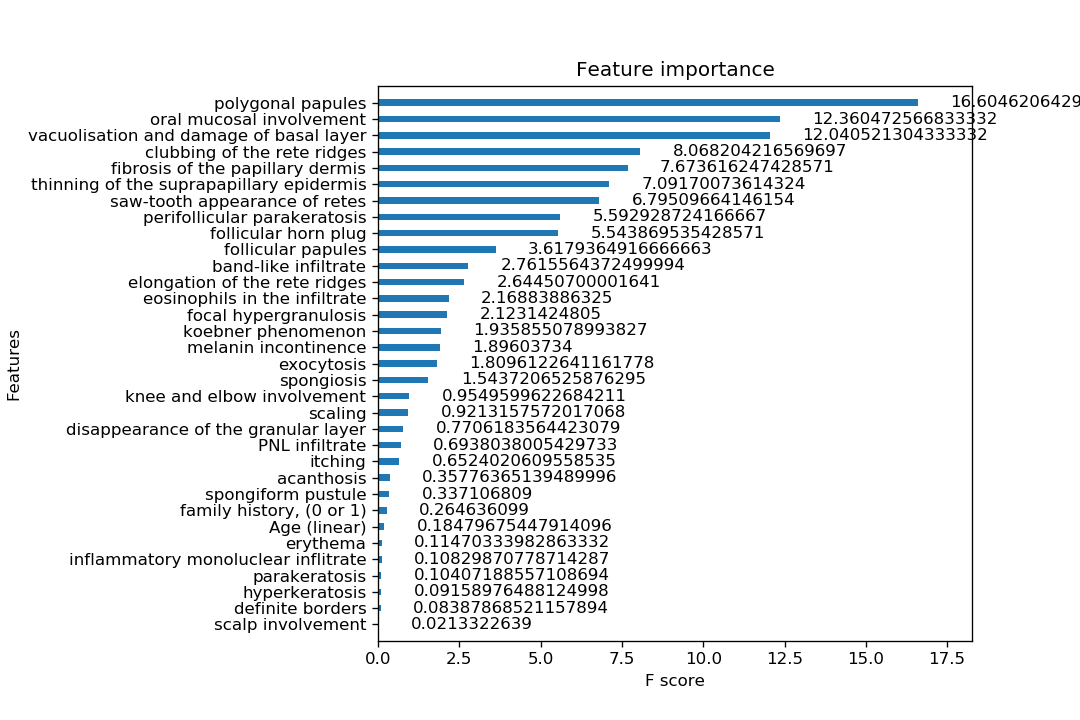

In [44]:
booster = grid_XGB.best_estimator_.named_steps['XGB']

#Default feature_importance_ values based on gain values
booster_features = pd.DataFrame(zip(X_train.columns, booster.feature_importances_),
                                 columns=['Feature_Name', 'Feature_Importance'])\
                                .sort_values(by='Feature_Importance', ascending=False)

# Output on FI >0 bc plot_importance only shows non-zero values
booster_features = booster_features.query('Feature_Importance > 0')
# booster_features.shape
# booster_features.head()


# feature_name

#Calculate different types of feature importance
k = booster.get_booster().trees_to_dataframe()
group = k[k['Feature']!='Leaf'].groupby('Feature').agg(fscore = ('Gain', 'count'),
                                                       feature_importance_gain =  ('Gain', 'mean'))

# Feature importance same as plot_importance(importance_type = 'weight'), default value
# group['fscore'].sort_values(ascending=False)

# Feature importance same as classifier.feature_importance_ default = 'gain'
# group['feature_importance_gain_norm'] = group['feature_importance_gain']/group['feature_importance_gain'].sum()
# group['feature_importance_gain_norm'].sort_values(ascending=False)

# Feature importance same as plot_importance(importance_type = 'gain')
booster_features['Gain'] = group['feature_importance_gain'].sort_values(ascending=False).values
booster_features['f_name'] = group['feature_importance_gain'].sort_values(ascending=False).index
# booster_features.head().append(booster_features.tail())


feature_name = booster_features.sort_values(by='Gain')['Feature_Name']

%matplotlib notebook
fig, ax2 = plt.subplots(figsize=(9,6))
xgb.plot_importance(booster.get_booster(), height = 0.4, grid = False, ax=ax2, importance_type='gain')
ax2.set_yticklabels(feature_name)
fig.subplots_adjust(left = 0.35);

### Why is the Top Feature the Top Feature?

In [46]:
Xy_train = X_train.copy()
Xy_train['Class_Code'] = y_train
# Xy_train
Xy_train.groupby('Class_Code')['polygonal papules'].mean()

Class_Code
1    0.00
2    0.00
3    2.34
4    0.00
5    0.00
6    0.00
Name: polygonal papules, dtype: float64

### Consolidate All Test Scores

In [58]:
#Consolidate test results from all algorithms
test_results = [test_results_dummy[:-2], 
                test_results_lr[:-2],
                test_results_sv[:-2],
                test_results_rf[:-2],
                test_results_gb[:-2],
                test_results_XGB[:-2],
                test_results_XGB_noimpute[:-2]]
test_pred = [test_results_dummy[-2:], 
             test_results_lr[-2:],
             test_results_sv[-2:],
             test_results_rf[-2:],
             test_results_gb[-2:],
             test_results_XGB[-2:],
             test_results_XGB_noimpute[-2:]]
test_results_name = ['Dummy', 'LogReg', 'SVC', 'RF', 'GB', 'XGB', 'XGB_noimpute']              
results = pd.DataFrame(test_results,             
             columns=['Accuracy', 'AUC', 'Kappa', 'F1'],
            index=test_results_name)
results

,Accuracy,AUC,Kappa,F1
Dummy,0.309091,0.500000,0.000000,0.078704
LogReg,0.963636,0.997557,0.954404,0.959259
SVC,0.954545,0.993208,0.943023,0.949309
RF,0.963636,0.997389,0.954347,0.957692
GB,0.954545,0.997136,0.942987,0.948742
XGB,0.972727,0.997590,0.965771,0.968661
XGB_noimpute,0.963636,0.994582,0.954347,0.957692


- Imputing missing values yielded better f1 score

In [ ]:
# mean_test_f1_macro
# DM  0.077830
# LR  0.96957
# SVC 0.982268
# RF  0.986712
# GB  0.983688
# XGB 0.978337

### Visualize Model Performance with ROC and PRC

<IPython.core.display.Javascript object>


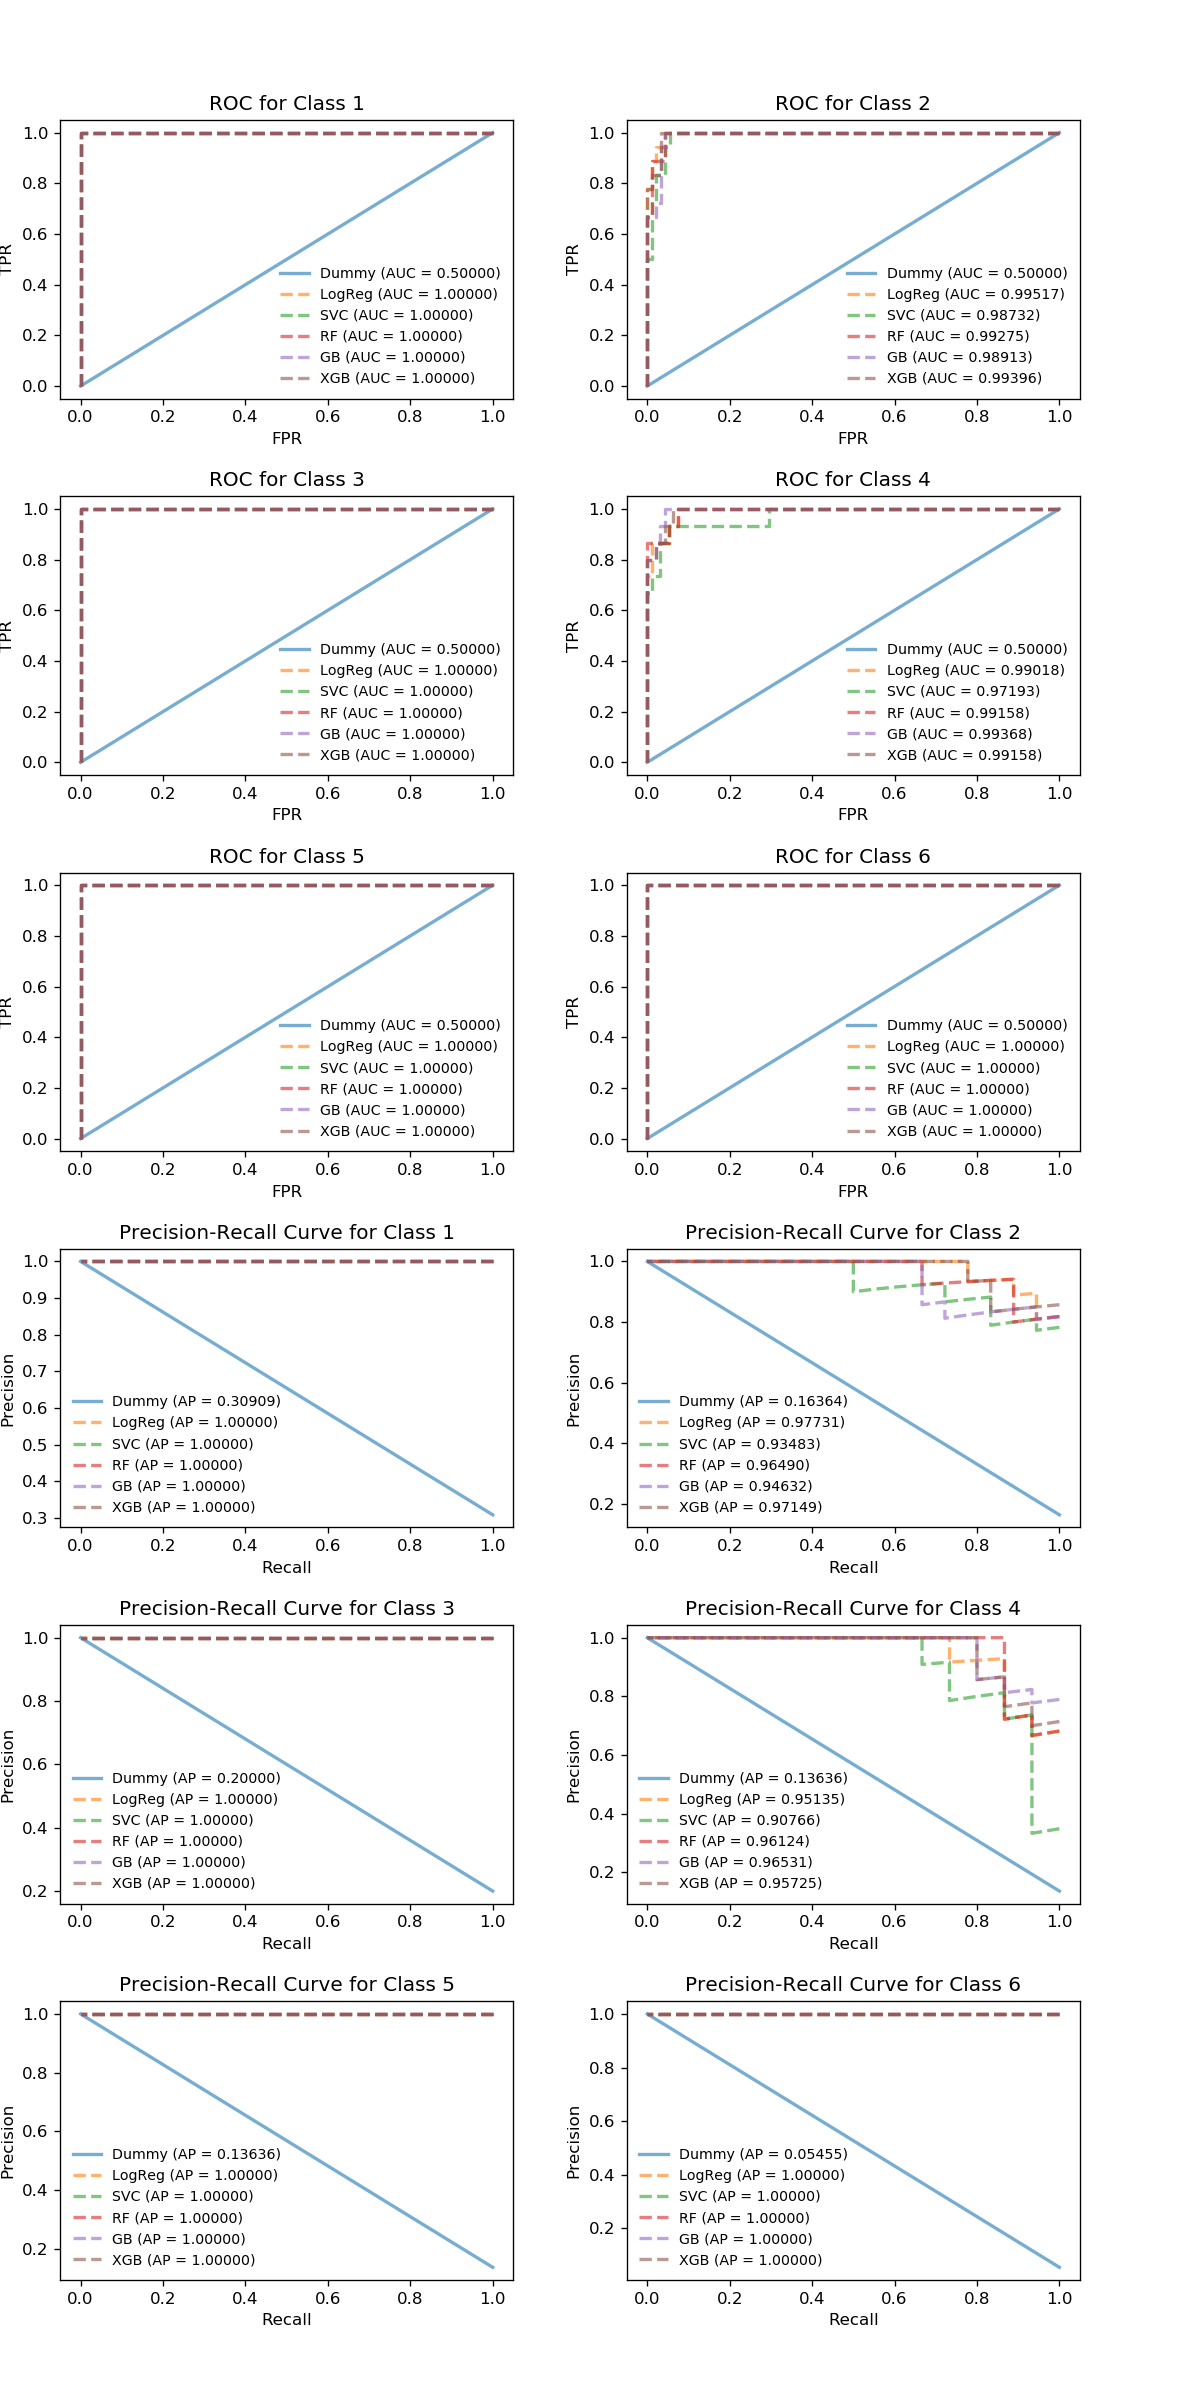

Test Results for Dummy Classifier:

Mean AUC: 0.50000
Mean f1 score (aka macro): 0.07870
Mean average precision score: 0.16667

Test Results for LogReg Classifier:

Mean AUC: 0.99756
Mean f1 score (aka macro): 0.95926
Mean average precision score: 0.98811

Test Results for SVC Classifier:

Mean AUC: 0.99321
Mean f1 score (aka macro): 0.94931
Mean average precision score: 0.97375

Test Results for RF Classifier:

Mean AUC: 0.99739
Mean f1 score (aka macro): 0.95769
Mean average precision score: 0.98769

Test Results for GB Classifier:

Mean AUC: 0.99714
Mean f1 score (aka macro): 0.94874
Mean average precision score: 0.98527

Test Results for XGB Classifier:

Mean AUC: 0.99759
Mean f1 score (aka macro): 0.96866
Mean average precision score: 0.98812



In [59]:
#Binarize y_test so that there are six 0/1 columns, one for each class
y_test_bin = label_binarize(y_test, classes=[1,2,3,4,5,6])
n_classes = y_test.nunique()
mean_ap=[]
    
#Plot ROC curve 
%matplotlib notebook
fig, [[ax1, ax2],[ax3, ax4], [ax5, ax6],\
      [ax21, ax22], [ax23, ax24], [ax25, ax26]] = plt.subplots(nrows = 6, ncols = 2, figsize = (10,20))

for test_pred_, label, ls in zip(test_pred[0:-1], test_results_name[0:-1], ['-']+['--']*len(test_pred[0:-1])):
    y_pred = test_pred_[0]
    y_scores = test_pred_[1]

    y_pred_bin = label_binarize(y_pred, classes=[1,2,3,4,5,6])


    acc=[]
    precision=[]
    recall=[]
    f1=[]
    ap=[]
    rocauc=[]
    # auc_=[]



    for i, ax, ax_prc in zip(range(n_classes), [ax1, ax2, ax3, ax4, ax5, ax6], [ax21, ax22, ax23, ax24, ax25, ax26]):
        acc.append(accuracy_score(y_test_bin[:, i], y_pred_bin[:, i]))
#         precision.append(precision_score(y_test_bin[:, i], y_pred_bin[:, i], zero_division=0))
#         recall.append(recall_score(y_test_bin[:, i], y_pred_bin[:, i], zero_division=0))
        f1.append(f1_score(y_test_bin[:, i], y_pred_bin[:, i], zero_division=0))
        ap.append(average_precision_score(y_test_bin[:, i], y_scores[:, i], average='macro', pos_label=1))
        rocauc.append(roc_auc_score(y_test_bin[:, i], y_scores[:, i]))
        #auc_.append(auc(fpr, tpr)) # same as using roc_auc_score
        
        #Plot ROC Curves
        fpr, tpr, thres = roc_curve(y_test_bin[:, i], y_scores[:, i])
        ax.plot(fpr, tpr,
                linestyle = ls, lw = 2, alpha = 0.6,
                label = '{} (AUC = {:.5f})'.format(label, rocauc[i]))
        ax.set_title('ROC for Class {}'.format(i+1))
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower right', frameon=False, fontsize=8.5)

    
        #Plot precision-recall curves
        precision, recall, thres = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
        ax_prc.plot(recall, precision,
                linestyle = ls, lw = 2, alpha = 0.6,
                label = '{} (AP = {:.5f})'.format(label, ap[i]))
        ax_prc.set_title('Precision-Recall Curve for Class {}'.format(i+1))
        ax_prc.set_xlabel('Recall')
        ax_prc.set_ylabel('Precision')
        ax_prc.legend(loc='lower left', frameon=False, fontsize=8.5)

        fig.subplots_adjust(left=0.05, top = 0.95, bottom = 0.05, hspace=0.35, wspace=0.25)
        
    print('Test Results for {} Classifier:\n'.format(label))
    print('Mean AUC: {:.5f}'.format(np.mean(rocauc))) 
    print('Mean f1 score (aka macro): {:.5f}'.format(np.mean(f1)))
    print('Mean average precision score: {:.5f}'.format(np.mean(ap)))
    print()
    mean_ap.append(np.mean(ap))
pass;

### Summarize All Evaluation Metrics

In [60]:
mean_ap.append(None)
results['Mean AP'] = mean_ap
results.sort_values(by='F1', ascending=False)

,Accuracy,AUC,Kappa,F1,Mean AP
XGB,0.972727,0.997590,0.965771,0.968661,0.988122
LogReg,0.963636,0.997557,0.954404,0.959259,0.988111
RF,0.963636,0.997389,0.954347,0.957692,0.987691
XGB_noimpute,0.963636,0.994582,0.954347,0.957692,NaN
SVC,0.954545,0.993208,0.943023,0.949309,0.973747
GB,0.954545,0.997136,0.942987,0.948742,0.985272
Dummy,0.309091,0.500000,0.000000,0.078704,0.166667


### Comments

#### Results
- Based on F1-macro score, the `winning model is XGBoost!`
- XGBoost has the highest values for other metrics as well except for AUC(ROC)
- XGBoost with missing value imputation achieved higher F1 score than without imputation
    - It might be data-dependent, need larger sample size to justify this

- Surprisingly, gradient boosting didn't do better than other skillful classifiers
- SVC had the worst area under precision-recall curve
- F1 score is more differentiating than AUC(ROC)
    - This phenonmenon can also be observed in ROC vs precision-recall curve (PRC)
    - With skewed class distributions, especially when modifying multiclass classification problem to one-over-rest (ovr) classification, large amount of true negatives gives rise to low false positive rate and hence too optimistic AUC(ROC)
- Dummy classifier, as expected, has zero predicting power; its kappa is no better than chance agreement
- Mean AP for XGBoost no-impute version is intentionally skipped

#### About choosing evaluation metrics
- F1-macro, average precision, and Cohen's kappa are preferred to accuracy and AUC(ROC) when classes are imbalanced 


- As with many other classification problems with multi-, imbalanced class data, this exercise aims at classifying the minority (i.e. positive) class correctly. Therefore, evaluation metrics stressing on the positive class are more applicable than accuracy and AUC, which can exaggerate prediction success due to huge amount of true negatives from the majority (i.e. negative) class. Some metric options like precision (proportion of predicted positives being truly positive) and recall (proportion of ground true positives being predicted correctly) are good candidates. For the sake of convenience when comparing models, it is handy to summarize the inversely related precision and recall scores with averaged F1 and mean average precision. When averaging F1 scores, macro-averaging is chosen over micro-averaging because with macro-averaging, the score from each class is weighted equally without bias from the dominant class. Average precision, just like AUC(ROC), summarizes the precision-recall curve (PRC). It is a recall-weighted average precision and is used to represent as the area under PRC. It is not strictly equal to area under curve as the area is not linear interpolated. 


- Cohen's kappa is another excellent choice here as it measures the agreement between true labels and predictions adjusted for chance agreement for >=2 classes regardless of class imbalance.


#### About tuning models
- The models sometimes after fine-tuning hyperparameters resulted in worse test score
    - Maybe the test set was too small to include the same data structure as the training set
    
    
- For XGBoost, once number of iterations and learning rate were set, there was not much room for model improvement by tuning other hyperparameters

#### About class weight vs sample weight
- Since gradient boost and XGBoost algorithms do not have `class_weight` parameter, to adjust for class imbalance, class weights are calculated and applied to each instance as `sample_weight` argument in fit() method
- Not sure why class_weight = 'balanced' specification achieved a better cv test score than class weights calculated as k/sum(k), where k = class_weight.compute_class_weight('balanced')

#### About refit scoring
- When multiple sets of hyperparameters have the same best cv test score, it is not sure how grid search picks the best set of hyperparameters, or best_index_ (suspect it picks the one with the lowest number of iterations). This decision making logic: Max(F1-macro) > Max(Accuracy) > Max(AUROC), is implemented as user-defined callabe argument for grid search `refit` scoring.

#### Improvement
- It would be better to start with a dataset of decent size
- Current dataset has n = 366 obs vs 34 features --, after 70/30 train-test split the training set is left with 256 obs for 5-fold cv